Plan of experimentation : 

- Sanity check 
- 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, f_oneway, median_test
from collections import defaultdict
from numba import njit


## Implementation of the Shapelet Generation

Here is the original pseudo code from the paper : 

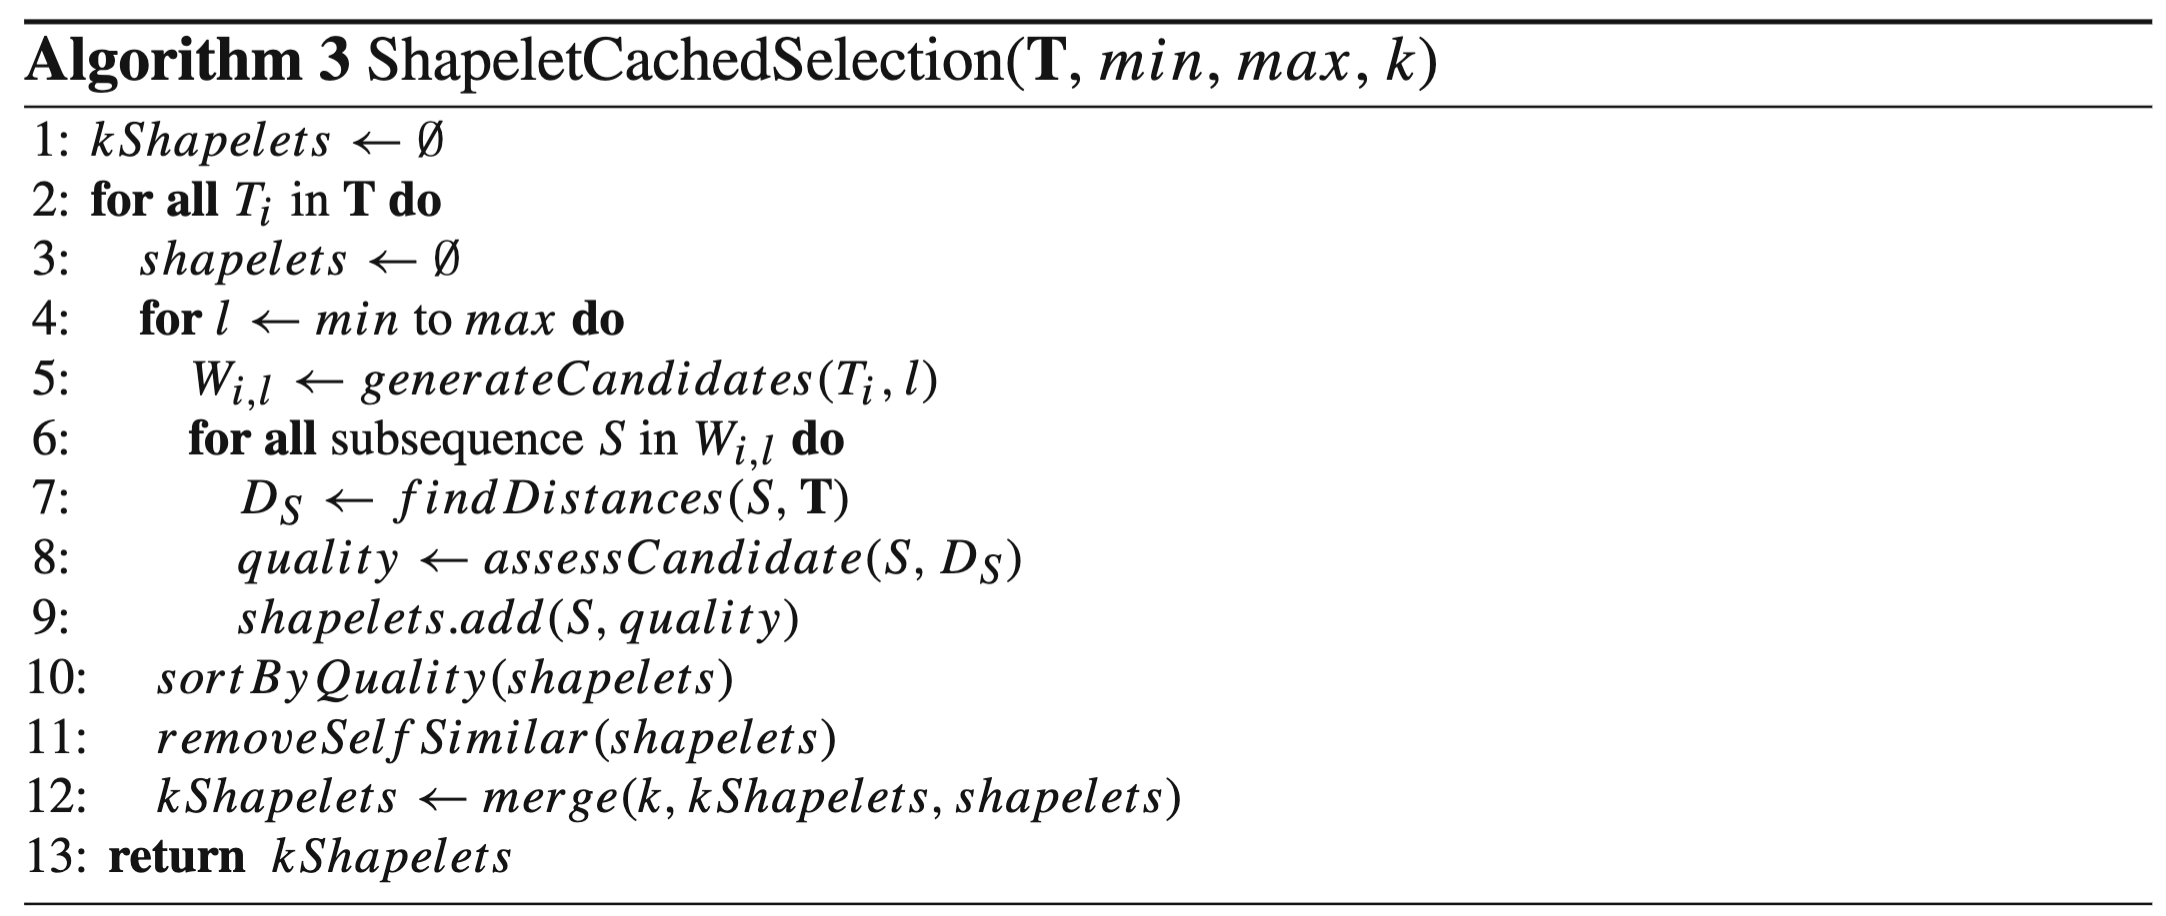

### Utils for handling shapelet data

In [37]:
from dataclasses import dataclass

@dataclass
class Shapelet:
    series_id: int
    start: int
    length: int
    quality: float
    data: any = None  # optionnel


In [38]:
def generateCandidates(t_i,l) :
    """
    Generate m-l+1 shapelet candidates 
    """
    W_i_l = []
    m = t_i.shape[0]
    for j in range(m-l+1) : 
        candidate = t_i[j:j+l]
        W_i_l.append(candidate)
    return W_i_l

In [39]:
def euclidean_distance(x,y) : 
    return np.sum((x-y)**2)

def z_normalize(x, eps=1e-8):
    mu = np.mean(x)
    sigma = np.std(x)
    if sigma < eps:
        return np.zeros_like(x)
    return (x - mu) / sigma


@njit(fastmath=True)
def findDistances(series_array, shapelet_array):
    """
    Numba optimized version of finding the minimum distance 
    between a shapelet and a dataset of time series.
    series_array: (N, M) array
    shapelet_array: (L,) array
    """
    n_series, series_len = series_array.shape
    shap_len = shapelet_array.shape[0]
    s_mean = np.mean(shapelet_array)
    s_std = np.std(shapelet_array)
    if s_std == 0: s_std = 1.0
    s_norm = (shapelet_array - s_mean) / s_std
    output_distances = np.zeros(n_series)
    
    for i in range(n_series):
        ts = series_array[i]
        best_dist = np.inf
        
        for j in range(series_len - shap_len + 1):

            
            w_sum = 0.0
            w_sq_sum = 0.0
            for k in range(shap_len):
                val = ts[j + k]
                w_sum += val
                w_sq_sum += val * val
            w_mean = w_sum / shap_len
            w_std = np.sqrt((w_sq_sum / shap_len) - (w_mean * w_mean))
            if w_std == 0: w_std = 1.0
            
            current_dist = 0.0
            abandon = False
            for k in range(shap_len):
                val_norm = (ts[j + k] - w_mean) / w_std
                diff = val_norm - s_norm[k]
                current_dist += diff * diff
                # Early Abandonment
                if current_dist >= best_dist:
                    abandon = True
                    break
            if not abandon:
                best_dist = current_dist                
        output_distances[i] = best_dist
    return output_distances

### Utils for assessing the quality of the shapelets

In [40]:
def split_by_class(D_S, y):
    """
    Return a dict {class: np.array(distances)}
    """
    groups = defaultdict(list)
    for d, label in zip(D_S, y):
        groups[label].append(d)
    return {k: np.array(v) for k, v in groups.items()}

def information_gain(D_S, y):
    """
    Information Gain computation for all different splits
    """
    D_S = np.asarray(D_S)
    y = np.asarray(y)

    order = np.argsort(D_S)
    D_sorted = D_S[order]
    y_sorted = y[order]

    def entropy(labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-12))

    base_entropy = entropy(y_sorted)
    best_ig = 0.0

    for i in range(1, len(D_sorted)):
        left = y_sorted[:i]
        right = y_sorted[i:]
        ig = base_entropy
        ig -= (len(left) / len(y)) * entropy(left)
        ig -= (len(right) / len(y)) * entropy(right)
        best_ig = max(best_ig, ig)

    return best_ig

def f_statistic(D_S, y):
    """
    ANOVA F-statistic 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return f_oneway(*groups.values()).statistic

def kruskal_wallis(D_S, y):
    """
    Test of Kruskal-Wallis 
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    return kruskal(*groups.values()).statistic

def moods_median(D_S, y):
    """
    Mood's median test (statistique du test)
    """
    groups = split_by_class(D_S, y)
    if len(groups) < 2:
        return 0.0
    stat, _, _, _ = median_test(*groups.values())
    return stat

def assessCandidate(D_S, y, method="f_stat"):
    """
    Wrapper function to asses the quality of a shapelet 
    method : {"f_stat", "ig", "kruskal", "median"}
    """
    if method == "f_stat":
        return f_statistic(D_S, y)
    elif method == "ig":
        return information_gain(D_S, y)
    elif method == "kruskal":
        return kruskal_wallis(D_S, y)
    elif method == "median":
        return moods_median(D_S, y)
    else:
        raise ValueError(f"Méthode inconnue : {method}")


In [20]:
def sort_by_quality(shapelets, reverse=True):
    """
    Sort the shapelet by their quality 

    shapelets : liste of tuples (shapelet, quality)
    reverse   : True = best quality in first position
    """
    return sorted(shapelets, key=lambda x: x.quality, reverse=reverse)



In [21]:
def overlaps(s1, s2):
    """
    Check if two shapelets does overlap
    """
    end1 = s1.start + s1.length - 1
    end2 = s2.start + s2.length - 1
    return not (end1 < s2.start or end2 < s1.start)


def remove_self_similar(shapelets):
    """
    - shapelets : list(Shapelet) 
    - shapelets is already ordered by decreasing quality
    """
    filtered = []

    for s in shapelets:
        keep = True
        for kept in filtered:
            if s.series_id == kept.series_id and overlaps(s, kept):
                keep = False
                break
        if keep:
            filtered.append(s)

    return filtered


#### Personal addition

In [22]:
def remove_inter_series_redundancy(shapelets, threshold_ratio=0.2):
    """
    Removes shapelets that are geometrically similar but come from DIFFERENT series.
    threshold_ratio: similarity threshold (e.g., 0.2 means distance must be < 20% of length)
    """
    final_shapelets = []
    
    # assume candidates are already sorted by quality 
    for candidate in shapelets:
        is_redundant = False
        cand_data = z_normalize(candidate.data)
        
        for kept in final_shapelets:
            # We only compare if lengths are similar 
            if len(candidate.data) == len(kept.data):
                kept_data = z_normalize(kept.data)
                
                # Calculate distance between the shapes themselves
                dist = np.linalg.norm(cand_data - kept_data) 
                
                # Heuristic: if distance is small relative to length
                if dist < (threshold_ratio * np.sqrt(len(cand_data))):
                    is_redundant = True
                    break
        
        if not is_redundant:
            final_shapelets.append(candidate)
            
    return final_shapelets

def shapelet_to_shapelet_distance(s1, s2):
    """
    use the finddistance function to find the min distance between two shapelets (using z-norm, sliding)
    """
    return findDistances(np.array([s1.data]), s2.data)[0]

# Second implementation, this time checking also the redudancy 
# between time series of differents sizes 
def greedy_inter_series_filter(shapelets, K, tau):
    """
    shapelets : list[Shapelet] (déjà triées par qualité décroissante)
    """
    selected = []

    for s in shapelets:
        keep = True
        for s_sel in selected:
            if shapelet_to_shapelet_distance(s, s_sel) < tau:
                keep = False
                break

        if keep:
            selected.append(s)

        if len(selected) == K:
            break

    return selected

#### Back to paper

In [23]:
def merge(k, k_shapelets, new_shapelets):
    """
    Merge the new shapelets with the old ones and keep the k best 

    Parameters
    ----------
    k : int
        max number of shapelets to keep
    k_shapelets : list[Shapelet]
        old shapelets 
    new_shapelets : list[Shapelet]
        New shapelets 

    Returns 
    ------
    list[Shapelet]
        top-k shapelets sorted by decreasing quality
    """
    merged = k_shapelets + new_shapelets
    merged.sort(key=lambda s: s.quality, reverse=True)
    return merged[:k]

In [24]:
def ShapeletCachedSelection(
    T,
    y,
    min_len,
    max_len,
    k,
    quality_method="f_stat"
):
    """
    Implementation of the algorithm 3 

    Parameters : 
    ----------
    T : np.ndarray (n_series, series_length)
        Dataset of time series
    y : np.ndarray (n_series,)
        Labels 
    min_len : int
        minimum lenght of the shapelets 
    max_len : int
        maximum lenght of the shapelets
    k : int
        Number of Shapelets kept 
    quality_method : str
        {"f_stat", "ig", "kruskal", "median"}

    Returns : 
    ------
    list[Shapelet]
        containing the k best Shapelets 
    """
    n_series, series_length = T.shape
    kShapelets = []  
    for series_id in range(n_series):
        t = T[series_id]
        shapelets = []  
        for l in range(min_len, max_len + 1):
            if l > series_length:
                continue
            for start in range(series_length - l + 1):
                S = t[start:start + l]
                D_S = findDistances(T, S)
                quality = assessCandidate(D_S, y, method=quality_method)
                shapelets.append(
                    Shapelet(
                        series_id=series_id,
                        start=start,
                        length=l,
                        quality=quality,
                        data=S
                    )
                )
        shapelets = sort_by_quality(shapelets)
        shapelets = remove_self_similar(shapelets)
        kShapelets = merge(k, kShapelets, shapelets)

    return kShapelets


In [25]:
def EstimateMinAndMax(T, y):
    """
    Heuristic to find min_len and max_len (Algorithm 4 in the paper)
    """
    n_samples = min(10, len(T))
    indices = np.random.choice(len(T), n_samples, replace=False)
    sub_T = T[indices]
    sub_y = y[indices]
    
    # Run a quick search with broad limits
    # (e.g., from 3 to length/2)
    quick_shapelets = ShapeletCachedSelection(
        sub_T, sub_y, 
        min_len=3, max_len=T.shape[1]//2, 
        k=10, quality_method="f_stat"
    )
    
    lengths = sorted([s.length for s in quick_shapelets])
    if not lengths:
        return 3, T.shape[1]//2
        
    min_l = lengths[len(lengths)//4] # 25th percentile
    max_l = lengths[3*len(lengths)//4] # 75th percentile
    
    return min_l, max_l

## Sanity Check with toy dataset

In [13]:
np.random.seed(0)

def generate_synthetic_dataset(
    n_series=20,
    series_length=100,
    shapelet_length=15
):
    X = np.random.normal(0, 1, (n_series, series_length))
    y = np.zeros(n_series, dtype=int)

    # shapelets for each class
    shapelet_A = np.sin(np.linspace(0, np.pi, shapelet_length))
    shapelet_B = -shapelet_A

    for i in range(n_series):
        pos = np.random.randint(0, series_length - shapelet_length)
        if i < n_series // 2:
            X[i, pos:pos+shapelet_length] += shapelet_A
            y[i] = 0
        else:
            X[i, pos:pos+shapelet_length] += shapelet_B
            y[i] = 1

    return X, y, shapelet_A, shapelet_B


X, y, true_A, true_B = generate_synthetic_dataset()


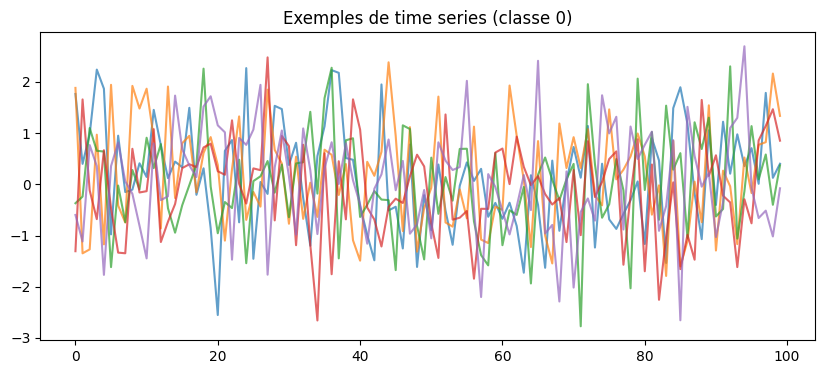

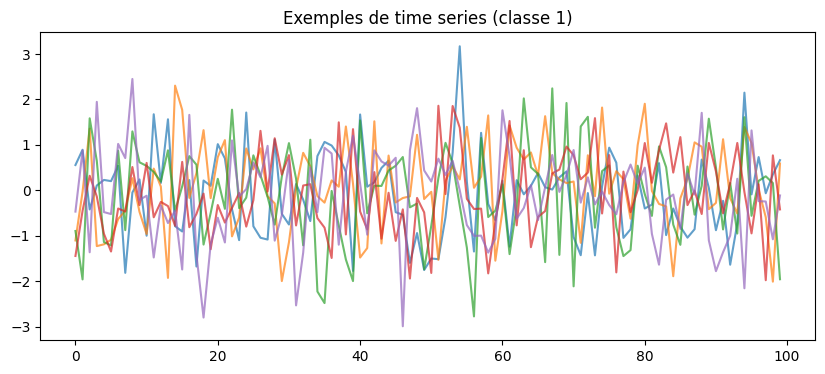

In [14]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 0)")
plt.show()

plt.figure(figsize=(10, 4))
for i in range(10, 15):
    plt.plot(X[i], alpha=0.7)
plt.title("Exemples de time series (classe 1)")
plt.show()


Shapelets sélectionnés :
series=10, start=80, len=10, quality=19.907
series=12, start=2, len=13, quality=16.448
series=6, start=13, len=12, quality=15.941
series=15, start=45, len=11, quality=14.462
series=13, start=47, len=10, quality=12.174


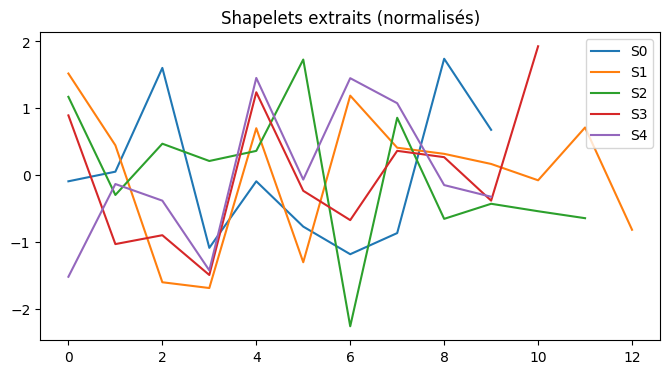

In [58]:
k_shapelets = ShapeletCachedSelection(
    T=X,
    y=y,
    min_len=10,
    max_len=20,
    k=5,
    quality_method="f_stat"
)

print("Shapelets sélectionnés :")
for s in k_shapelets:
    print(
        f"series={s.series_id}, start={s.start}, "
        f"len={s.length}, quality={s.quality:.3f}"
    )

    
plt.figure(figsize=(8, 4))
for i, s in enumerate(k_shapelets):
    plt.plot(z_normalize(s.data), label=f"S{i}")
plt.title("Shapelets extraits (normalisés)")
plt.legend()
plt.show()


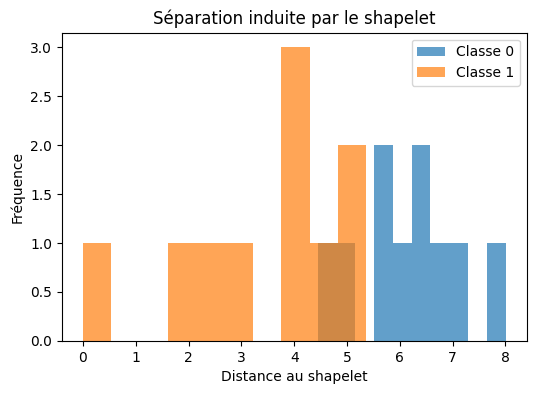

In [59]:
best_shapelet = k_shapelets[0]
D = findDistances(X, best_shapelet.data)
plt.figure(figsize=(6, 4))
plt.hist(D[y == 0], bins=10, alpha=0.7, label="Classe 0")
plt.hist(D[y == 1], bins=10, alpha=0.7, label="Classe 1")
plt.xlabel("Distance au shapelet")
plt.ylabel("Fréquence")
plt.title("Séparation induite par le shapelet")
plt.legend()
plt.show()


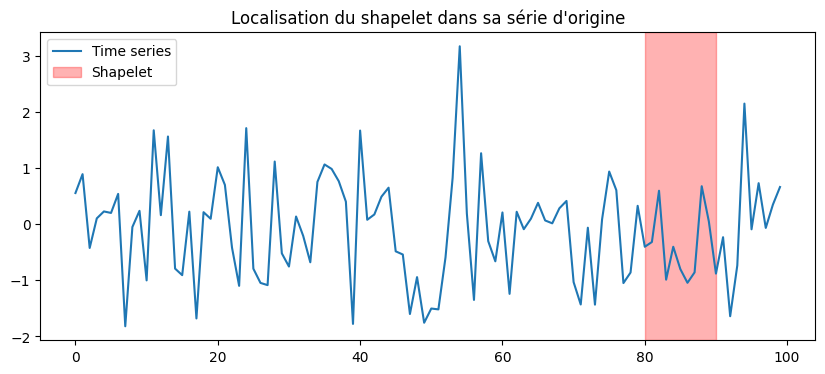

In [60]:
s = best_shapelet
t = X[s.series_id]

plt.figure(figsize=(10, 4))
plt.plot(t, label="Time series")
plt.axvspan(
    s.start,
    s.start + s.length,
    color="red",
    alpha=0.3,
    label="Shapelet"
)
plt.legend()
plt.title("Localisation du shapelet dans sa série d'origine")
plt.show()


# Gunpoint dataset analysis

In [64]:
import requests
import zipfile
import io
import numpy as np

def load_gunpoint():
    url = "https://www.timeseriesclassification.com/aeon-toolkit/GunPoint.zip"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
    }
    print(f"Downloading GunPoint from {url}...")
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        raise Exception(f"Failed to download. Status: {r.status_code}\nResponse: {r.text[:200]}")   
    if r.content[:2] != b'PK': 
        raise Exception("The downloaded file is not a zip archive. It might be an HTML page.")
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except zipfile.BadZipFile:
        with open("debug_download.html", "wb") as f:
            f.write(r.content)
        raise Exception("BadZipFile error. Saved 'debug_download.html' for inspection.")
    print("Files in archive:", z.namelist())
    
 
    try:
        train_file = z.open('GunPoint_TRAIN.txt')
        test_file  = z.open('GunPoint_TEST.txt')
    except KeyError:
        print("Text files not found, looking for .ts files...")

        raise Exception("Could not find GunPoint_TRAIN.txt. The archive format might have changed to .ts")

    train = np.loadtxt(train_file)
    test  = np.loadtxt(test_file)
    
    X_train = train[:, 1:]
    y_train = train[:, 0].astype(int)
    
    X_test = test[:, 1:]
    y_test = test[:, 0].astype(int)
    
    print(f"Loaded GunPoint: Train {X_train.shape}, Test {X_test.shape}")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_gunpoint()

Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)


--- 1. COMPLETENESS CHECK ---
Total missing values: 0
-> Status: Clean (No imputation needed).

--- 2. CLASS BALANCE CHECK ---
   Class  Count  Percentage
0      1     24        48.0
1      2     26        52.0
-> Status: Balanced (Accuracy is a valid metric).

--- 3. SCALE CONSISTENCY CHECK ---
Global Mean of Series Means: -0.00 (Std: 0.00)
Global Mean of Series Stds:  1.00 (Std: 0.00)
-> Status: Already Normalized.


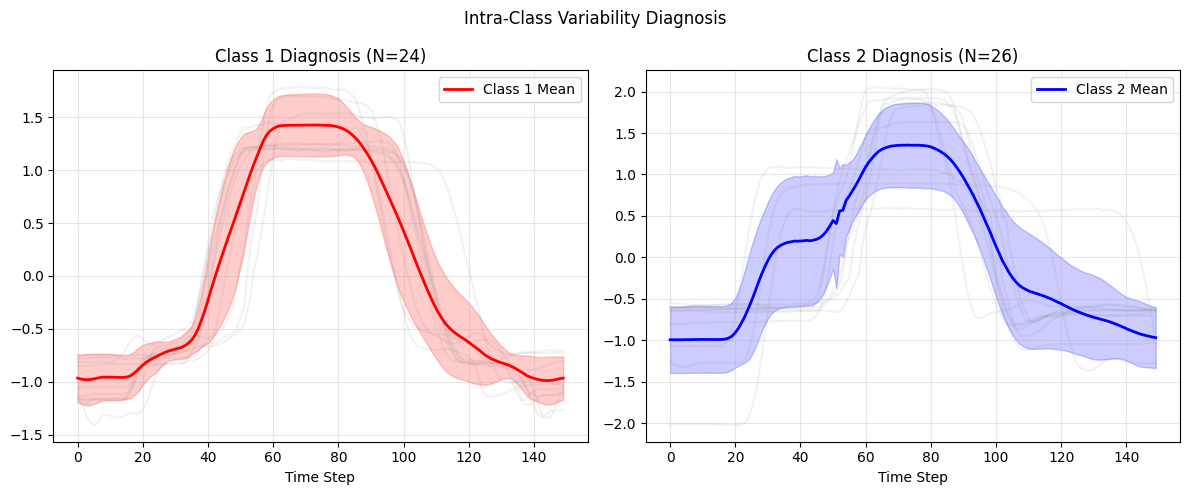

In [45]:
import pandas as pd
import seaborn as sns


def diagnose_dataset(X, y):
    print("--- 1. COMPLETENESS CHECK ---")
    n_nans = np.isnan(X).sum()
    print(f"Total missing values: {n_nans}")
    if n_nans == 0:
        print("-> Status: Clean (No imputation needed).")
    else:
        print("-> Status: Dirty (Imputation required).")

    print("\n--- 2. CLASS BALANCE CHECK ---")
    unique, counts = np.unique(y, return_counts=True)
    balance_df = pd.DataFrame({'Class': unique, 'Count': counts})
    balance_df['Percentage'] = balance_df['Count'] / len(y) * 100
    print(balance_df)
    
    if counts.min() / counts.max() > 0.8:
        print("-> Status: Balanced (Accuracy is a valid metric).")
    else:
        print("-> Status: Imbalanced (Consider F1-Score or resampling).")

    print("\n--- 3. SCALE CONSISTENCY CHECK ---")
    means = np.mean(X, axis=1)
    stds = np.std(X, axis=1)
    
    print(f"Global Mean of Series Means: {np.mean(means):.2f} (Std: {np.std(means):.2f})")
    print(f"Global Mean of Series Stds:  {np.mean(stds):.2f} (Std: {np.std(stds):.2f})")
    
    is_normalized = np.allclose(means, 0, atol=0.1) and np.allclose(stds, 1, atol=0.1)
    if is_normalized:
        print("-> Status: Already Normalized.")
    else:
        print("-> Status: Raw amplitudes (Z-normalization required in algorithm).")

    classes = np.unique(y)
    plt.figure(figsize=(12, 5))
    
    for i, c in enumerate(classes):
        plt.subplot(1, len(classes), i+1)
        X_c = X[y == c]
        
        mu = X_c.mean(axis=0)
        sigma = X_c.std(axis=0)
        
        for series in X_c[:10]: 
            plt.plot(series, color='gray', alpha=0.1)
            
        plt.plot(mu, linewidth=2, color='red' if c==1 else 'blue', label=f"Class {c} Mean")
        plt.fill_between(np.arange(len(mu)), mu-sigma, mu+sigma, alpha=0.2, color='red' if c==1 else 'blue')
        
        plt.title(f"Class {c} Diagnosis (N={len(X_c)})")
        plt.xlabel("Time Step")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
    plt.suptitle("Intra-Class Variability Diagnosis")
    plt.tight_layout()
    plt.show()

diagnose_dataset(X_train, y_train)


 GENERATING AMPLITUDE BOXPLOTS (Outlier Detection)...


/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/1074854945.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amplitude', data=df_box, palette="Set2")


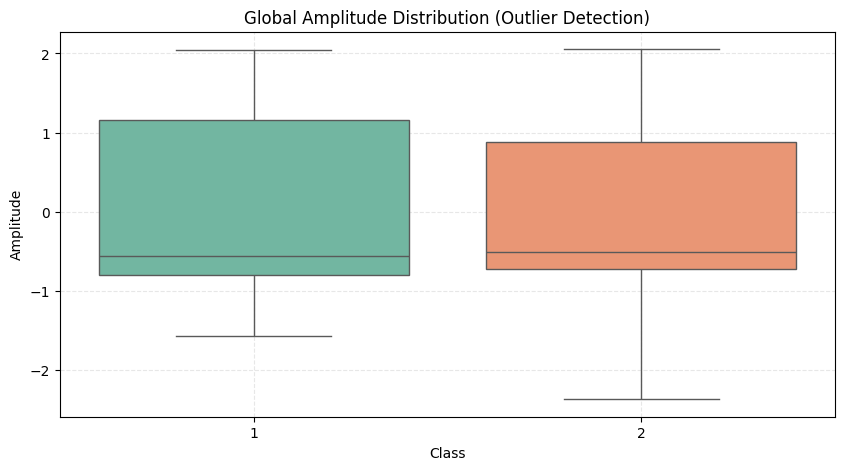


 SPECTRAL ANALYSIS (Welch's Method)...


/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/1074854945.py:32: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 150, using nperseg = 150
  freqs, psd = welch(X_c, fs=1.0)  # psd shape: (n_samples_c, n_freqs)


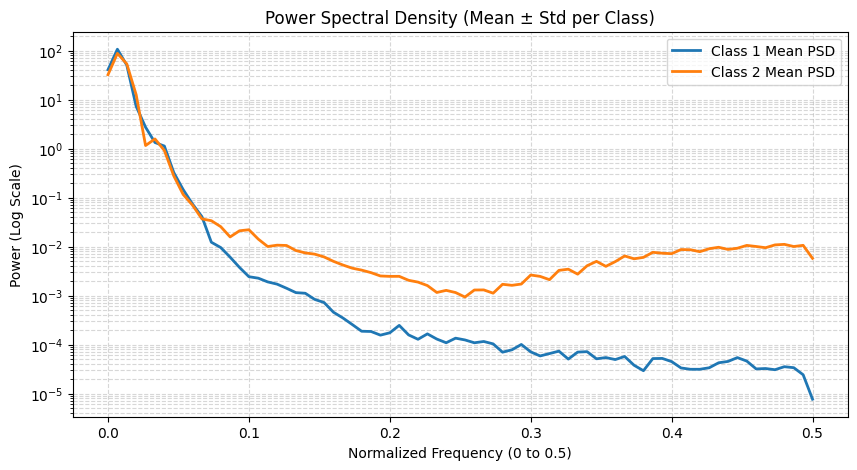

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

def run_full_data_diagnosis(X, y):

    print("\n GENERATING AMPLITUDE BOXPLOTS (Outlier Detection)...")
    
    df_box = pd.DataFrame({
        'Amplitude': X.flatten(),
        'Class': np.repeat(y, X.shape[1])
    })
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Class', y='Amplitude', data=df_box, palette="Set2")
    plt.title("Global Amplitude Distribution (Outlier Detection)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    classes = np.unique(y)

    print("\n SPECTRAL ANALYSIS (Welch's Method)...")
    
    plt.figure(figsize=(10, 5))
    
    for c in classes:
        X_c = X[y == c]

        # PSD for each signal
        freqs, psd = welch(X_c, fs=1.0)  # psd shape: (n_samples_c, n_freqs)

        mean_psd = psd.mean(axis=0)


        # Mean PSD
        plt.semilogy(freqs, mean_psd, linewidth=2, label=f"Class {c} Mean PSD")

        

    
    plt.title("Power Spectral Density (Mean ± Std per Class)")
    plt.xlabel("Normalized Frequency (0 to 0.5)")
    plt.ylabel("Power (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.show()


run_full_data_diagnosis(X_train, y_train)

/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/671284146.py:65: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 150, using nperseg = 150
  freqs, psd = welch(X_c, fs=fs, axis=1)
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/671284146.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/671284146.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


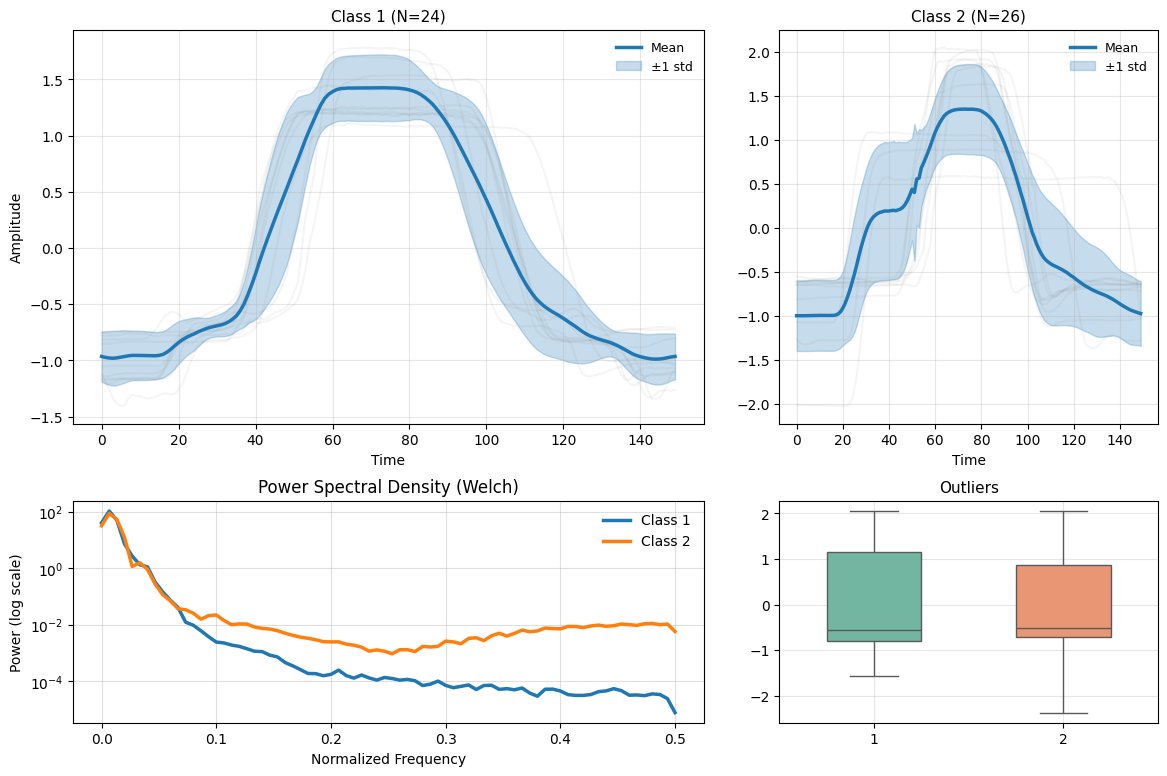

In [65]:
full_dataset_diagnosis_paper_ready(X_train, y_train)

## Experiment on Gunpoint

Estimated parameters: min_len=26, max_len=28

--- 1. Baseline: Standard Shapelet Transform ---
Extracting top 50 shapelets (Standard)...

--- 2. Our Method: Inter-Series Redundancy Filter ---
Reduced feature space from 50 -> 32 features.

--- 3. Training Classifiers ---
Transforming dataset shape (23, 136) with 50 shapelets...
Transforming dataset shape (861, 136) with 50 shapelets...
Transforming dataset shape (23, 136) with 32 shapelets...
Transforming dataset shape (861, 136) with 32 shapelets...

FINAL RESULTS TABLE
                Method  Num Features Accuracy Reduction
0  Standard (Baseline)            50   0.9977         -
1     Clustered (Ours)            32   1.0000     36.0%


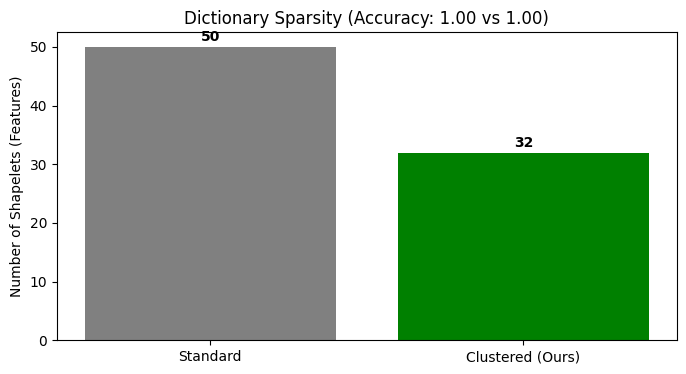

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def transform_dataset(X, shapelets):
    n_samples = len(X)
    n_features = len(shapelets)
    X_new = np.zeros((n_samples, n_features))
    
    print(f"Transforming dataset shape {X.shape} with {n_features} shapelets...")
    for i, s in enumerate(shapelets):
        X_new[:, i] = findDistances(X, s.data)
        
    return X_new

if 'X_train' not in locals():
    X_train, y_train, X_test, y_test = load_gunpoint()

min_l, max_l = EstimateMinAndMax(X_train, y_train)
print(f"Estimated parameters: min_len={min_l}, max_len={max_l}")

print("\n--- 1. Baseline: Standard Shapelet Transform ---")
k_baseline = 50
print(f"Extracting top {k_baseline} shapelets (Standard)...")

baseline_shapelets = ShapeletCachedSelection(
    X_train, y_train, 
    min_len=min_l, 
    max_len=max_l, 
    k=k_baseline, 
    quality_method="f_stat"
)

print("\n--- 2. Our Method: Inter-Series Redundancy Filter ---")
clustered_shapelets = remove_inter_series_redundancy(baseline_shapelets, threshold_ratio=0.25)
k_ours = len(clustered_shapelets)
print(f"Reduced feature space from {k_baseline} -> {k_ours} features.")

print("\n--- 3. Training Classifiers ---")

X_train_base = transform_dataset(X_train, baseline_shapelets)
X_test_base  = transform_dataset(X_test, baseline_shapelets)

X_train_ours = transform_dataset(X_train, clustered_shapelets)
X_test_ours  = transform_dataset(X_test, clustered_shapelets)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_base, y_train)
acc_base = accuracy_score(y_test, clf.predict(X_test_base))

clf.fit(X_train_ours, y_train)
acc_ours = accuracy_score(y_test, clf.predict(X_test_ours))

results = pd.DataFrame({
    'Method': ['Standard (Baseline)', 'Clustered (Ours)'],
    'Num Features': [k_baseline, k_ours],
    'Accuracy': [f"{acc_base:.4f}", f"{acc_ours:.4f}"],
    'Reduction': ['-', f"{(1 - k_ours/k_baseline)*100:.1f}%"]
})

print("\n" + "="*40)
print("FINAL RESULTS TABLE")
print("="*40)
print(results)
print("="*40)

plt.figure(figsize=(8, 4))
plt.bar(['Standard', 'Clustered (Ours)'], [k_baseline, k_ours], color=['gray', 'green'])
plt.title(f"Dictionary Sparsity (Accuracy: {acc_base:.2f} vs {acc_ours:.2f})")
plt.ylabel("Number of Shapelets (Features)")
for i, v in enumerate([k_baseline, k_ours]):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.show()

### Accuracy vs. k

Running Sensitivity Analysis (k vs Accuracy)...
Transforming dataset shape (50, 150) with 1 shapelets...
Transforming dataset shape (150, 150) with 1 shapelets...
k=1: Accuracy=0.9000
Transforming dataset shape (50, 150) with 5 shapelets...
Transforming dataset shape (150, 150) with 5 shapelets...
k=5: Accuracy=0.9467
Transforming dataset shape (50, 150) with 10 shapelets...
Transforming dataset shape (150, 150) with 10 shapelets...
k=10: Accuracy=0.9467
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
k=20: Accuracy=0.9467
Transforming dataset shape (50, 150) with 30 shapelets...
Transforming dataset shape (150, 150) with 30 shapelets...
k=30: Accuracy=0.9533
Transforming dataset shape (50, 150) with 40 shapelets...
Transforming dataset shape (150, 150) with 40 shapelets...
k=40: Accuracy=0.9733
Transforming dataset shape (50, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
k=50: A

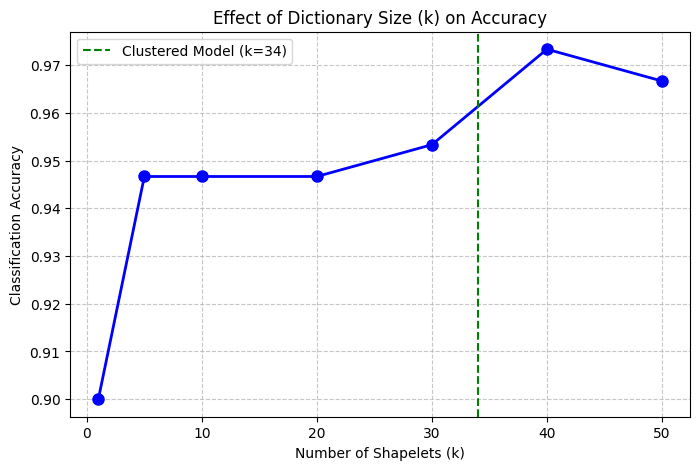

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

k_values = [1, 5, 10, 20, 30, 40, 50]
accuracies = []

print("Running Sensitivity Analysis (k vs Accuracy)...")

for k in k_values:
    current_shapelets = baseline_shapelets[:k]
    
    X_train_k = transform_dataset(X_train, current_shapelets)
    X_test_k  = transform_dataset(X_test, current_shapelets)
    
    clf_k = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_k.fit(X_train_k, y_train)
    
    acc = accuracy_score(y_test, clf_k.predict(X_test_k))
    accuracies.append(acc)
    print(f"k={k}: Accuracy={acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
plt.title("Effect of Dictionary Size (k) on Accuracy")
plt.xlabel("Number of Shapelets (k)")
plt.ylabel("Classification Accuracy")
plt.grid(True, linestyle='--', alpha=0.7)


if 'k_ours' in locals():
    plt.axvline(x=k_ours, color='green', linestyle='--', label=f"Clustered Model (k={k_ours})")
    plt.legend()

plt.show()

### Robustness to Noise

Training models on clean data...
Transforming dataset shape (50, 150) with 34 shapelets...

Running Noise Robustness Test (this may take a moment)...
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.0: Shapelet Acc=0.960 | Baseline Acc=0.913
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.5: Shapelet Acc=0.493 | Baseline Acc=0.887
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.0: Shapelet Acc=0.493 | Baseline Acc=0.807
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.5: Shapelet Acc=0.493 | Baseline Acc=0.767
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.0: Shapelet Acc=0.493 | Baseline Acc=0.653
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.5: Shapelet Acc=0.493 | Baseline Acc=0.707


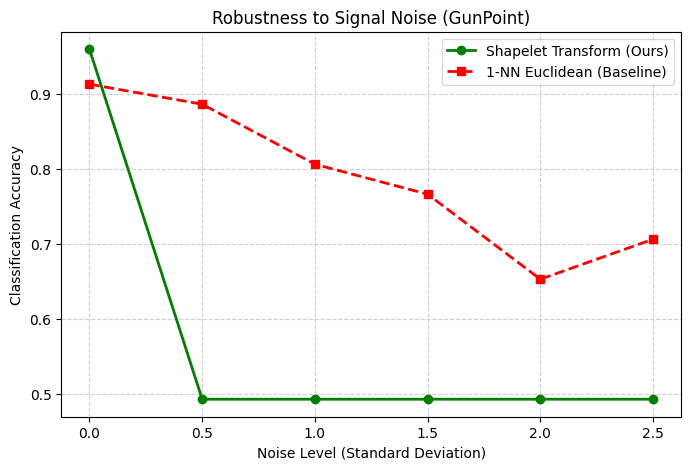

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


print("Training models on clean data...")


X_train_shap = transform_dataset(X_train, clustered_shapelets)
clf_shap = RandomForestClassifier(n_estimators=100, random_state=42)
clf_shap.fit(X_train_shap, y_train)


clf_base = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf_base.fit(X_train, y_train)

noise_levels = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5] 
acc_shapelet = []
acc_baseline = []

print("\nRunning Noise Robustness Test (this may take a moment)...")

for sigma in noise_levels:
    noise = np.random.normal(0, sigma, X_test.shape)
    X_test_noisy = X_test + noise

    X_test_shap_noisy = transform_dataset(X_test_noisy, clustered_shapelets)
    acc_s = accuracy_score(y_test, clf_shap.predict(X_test_shap_noisy))
    acc_shapelet.append(acc_s)
    
    acc_b = accuracy_score(y_test, clf_base.predict(X_test_noisy))
    acc_baseline.append(acc_b)
    
    print(f"Noise={sigma}: Shapelet Acc={acc_s:.3f} | Baseline Acc={acc_b:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(noise_levels, acc_shapelet, 'g-o', linewidth=2, label="Shapelet Transform (Ours)")
plt.plot(noise_levels, acc_baseline, 'r--s', linewidth=2, label="1-NN Euclidean (Baseline)")

plt.title("Robustness to Signal Noise (GunPoint)")
plt.xlabel("Noise Level (Standard Deviation)")
plt.ylabel("Classification Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### SVM vs RandomForest

Training classifiers on clean data...
Transforming dataset shape (50, 150) with 34 shapelets...

Running Noise Comparison (RF vs SVM)...
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.0: RF=0.960 | SVM=0.973
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=0.5: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.0: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=1.5: RF=0.493 | SVM=0.493
Transforming dataset shape (150, 150) with 34 shapelets...
Noise=2.0: RF=0.493 | SVM=0.493


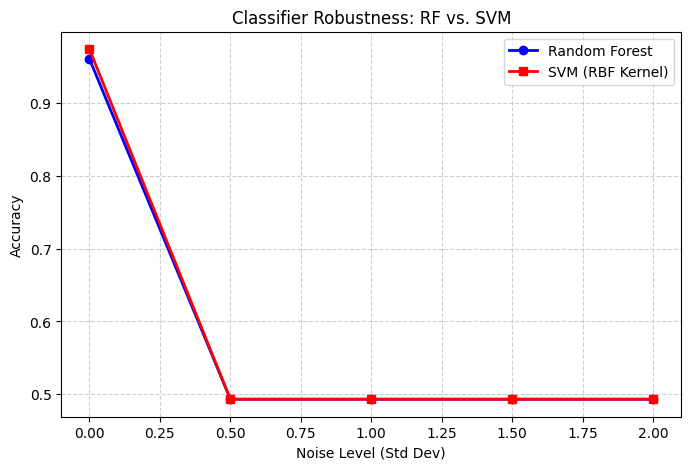

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)


svm_clf = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', C=1.0, probability=True) 
)


print("Training classifiers on clean data...")
X_train_trans = transform_dataset(X_train, clustered_shapelets)

rf_clf.fit(X_train_trans, y_train)
svm_clf.fit(X_train_trans, y_train)

noise_levels = [0.0, 0.5, 1.0, 1.5, 2.0]
rf_scores = []
svm_scores = []

print("\nRunning Noise Comparison (RF vs SVM)...")

for sigma in noise_levels:
    noise = np.random.normal(0, sigma, X_test.shape)
    X_test_noisy = X_test + noise
    

    X_test_trans = transform_dataset(X_test_noisy, clustered_shapelets)
    
    acc_rf = accuracy_score(y_test, rf_clf.predict(X_test_trans))
    rf_scores.append(acc_rf)
    
    acc_svm = accuracy_score(y_test, svm_clf.predict(X_test_trans))
    svm_scores.append(acc_svm)
    
    print(f"Noise={sigma}: RF={acc_rf:.3f} | SVM={acc_svm:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(noise_levels, rf_scores, 'b-o', linewidth=2, label="Random Forest")
plt.plot(noise_levels, svm_scores, 'r-s', linewidth=2, label="SVM (RBF Kernel)")

plt.title("Classifier Robustness: RF vs. SVM")
plt.xlabel("Noise Level (Std Dev)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Sensitivity to Speed Changes

Training Article Model (Standard)...
Transforming dataset shape (50, 150) with 50 shapelets...
Training Our Model (Clustered)...
Transforming dataset shape (50, 150) with 35 shapelets...

Running Warping Comparison...
Transforming dataset shape (150, 120) with 50 shapelets...
Transforming dataset shape (150, 120) with 35 shapelets...
Ratio 0.8: Art=0.900 | Ours=0.900
Transforming dataset shape (150, 135) with 50 shapelets...
Transforming dataset shape (150, 135) with 35 shapelets...
Ratio 0.9: Art=0.960 | Ours=0.967
Transforming dataset shape (150, 142) with 50 shapelets...
Transforming dataset shape (150, 142) with 35 shapelets...
Ratio 0.95: Art=0.960 | Ours=0.973
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Ratio 1.0: Art=0.953 | Ours=0.953
Transforming dataset shape (150, 157) with 50 shapelets...
Transforming dataset shape (150, 157) with 35 shapelets...
Ratio 1.05: Art=0.947 | Ours=0.947
Transforming dataset

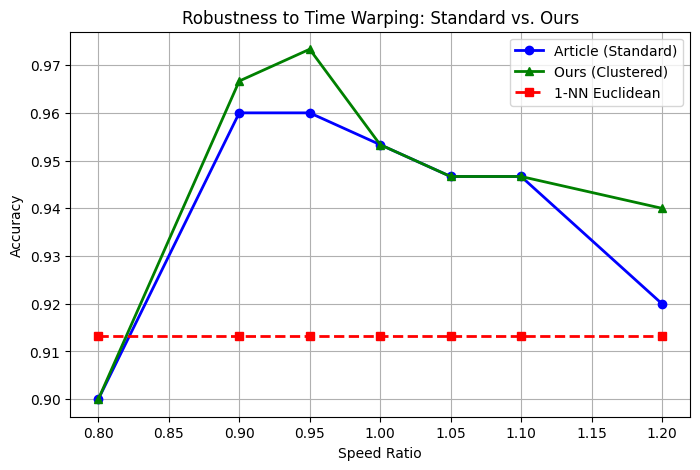

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


if 'baseline_shapelets' in locals():
    print("Training Article Model (Standard)...")
    X_train_base = transform_dataset(X_train, baseline_shapelets)
    clf_article = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_article.fit(X_train_base, y_train)
else:
    print("Error: 'baseline_shapelets' not found. Run the comparison block first!")

print("Training Our Model (Clustered)...")
X_train_ours = transform_dataset(X_train, clustered_shapelets)
clf_ours = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ours.fit(X_train_ours, y_train)

clf_1nn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf_1nn.fit(X_train, y_train)

warp_ratios = [0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2]
acc_article = []
acc_ours = []
acc_1nn = []

print("\nRunning Warping Comparison...")

for r in warp_ratios:
    X_test_warped = warp_dataset(X_test, ratio=r)
    
    X_test_base_warped = transform_dataset(X_test_warped, baseline_shapelets)
    acc_article.append(accuracy_score(y_test, clf_article.predict(X_test_base_warped)))
    
    X_test_ours_warped = transform_dataset(X_test_warped, clustered_shapelets)
    acc_ours.append(accuracy_score(y_test, clf_ours.predict(X_test_ours_warped)))
    
    X_test_fixed = resize_dataset(X_test_warped, target_length=X_train.shape[1])
    acc_1nn.append(accuracy_score(y_test, clf_1nn.predict(X_test_fixed)))
    
    print(f"Ratio {r}: Art={acc_article[-1]:.3f} | Ours={acc_ours[-1]:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(warp_ratios, acc_article, 'b-o', linewidth=2, label="Article (Standard)")
plt.plot(warp_ratios, acc_ours, 'g-^', linewidth=2, label="Ours (Clustered)")
plt.plot(warp_ratios, acc_1nn, 'r--s', linewidth=2, label="1-NN Euclidean")

plt.title("Robustness to Time Warping: Standard vs. Ours")
plt.xlabel("Speed Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Blackout (Occlusion) Test


Running Occlusion Comparison...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset sh

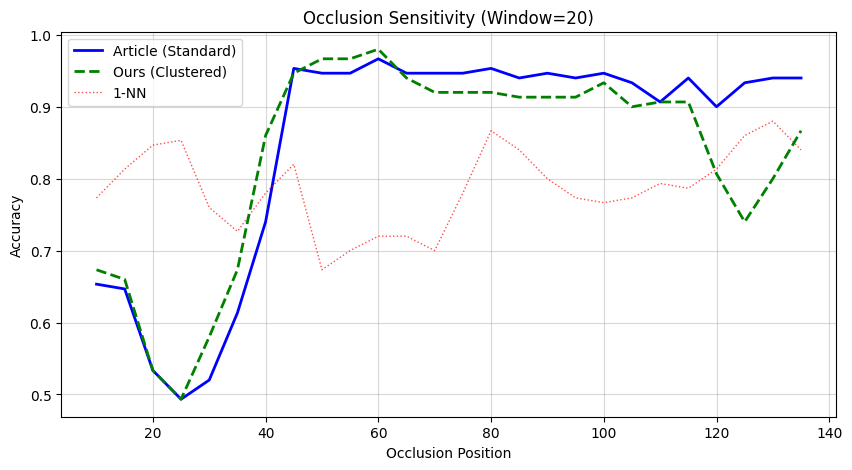

In [49]:
window_size = 20
step_size = 5
series_len = X_test.shape[1]

positions = []
acc_occ_article = []
acc_occ_ours = []
acc_occ_1nn = []

print(f"\nRunning Occlusion Comparison...")

for start in range(0, series_len - window_size, step_size):
    end = start + window_size
    mid = start + window_size // 2
    positions.append(mid)
    
    X_test_occ = X_test.copy()
    X_test_occ[:, start:end] = 0.0
    
    X_test_base_occ = transform_dataset(X_test_occ, baseline_shapelets)
    acc_occ_article.append(accuracy_score(y_test, clf_article.predict(X_test_base_occ)))
    
    X_test_ours_occ = transform_dataset(X_test_occ, clustered_shapelets)
    acc_occ_ours.append(accuracy_score(y_test, clf_ours.predict(X_test_ours_occ)))
    
    acc_occ_1nn.append(accuracy_score(y_test, clf_1nn.predict(X_test_occ)))

plt.figure(figsize=(10, 5))
plt.plot(positions, acc_occ_article, 'b-', linewidth=2, label="Article (Standard)")
plt.plot(positions, acc_occ_ours, 'g--', linewidth=2, label="Ours (Clustered)")
plt.plot(positions, acc_occ_1nn, 'r:', linewidth=1, alpha=0.7, label="1-NN")

plt.title(f"Occlusion Sensitivity (Window={window_size})")
plt.xlabel("Occlusion Position")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Data Starvation Test (Sample Efficiency)


Running Data Starvation Comparison...
Transforming dataset shape (4, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (4, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (4, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (4, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (4, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (4, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (4, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (4, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (4, 15

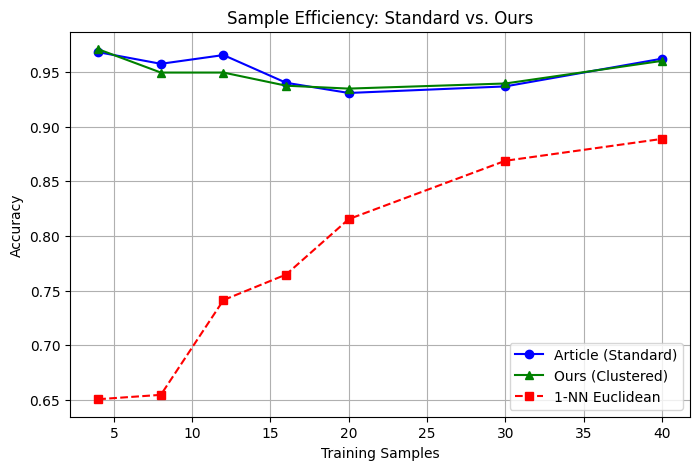

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

subset_sizes = [4, 8, 12, 16, 20, 30, 40]
n_repeats = 10

acc_starve_article = []
acc_starve_ours = []
acc_starve_1nn = []

print("\nRunning Data Starvation Comparison...")

for n in subset_sizes:
    s_art, s_ours, s_1nn = [], [], []
    
    for i in range(n_repeats):
        sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=i*n)
        for train_idx, _ in sss.split(X_train, y_train):
            X_sub = X_train[train_idx]
            y_sub = y_train[train_idx]
            
        X_sub_base = transform_dataset(X_sub, baseline_shapelets)
        clf_a = RandomForestClassifier(n_estimators=50, random_state=42)
        clf_a.fit(X_sub_base, y_sub)
        X_test_base = transform_dataset(X_test, baseline_shapelets)
        s_art.append(accuracy_score(y_test, clf_a.predict(X_test_base)))
        
        X_sub_ours = transform_dataset(X_sub, clustered_shapelets)
        clf_o = RandomForestClassifier(n_estimators=50, random_state=42)
        clf_o.fit(X_sub_ours, y_sub)
        X_test_ours = transform_dataset(X_test, clustered_shapelets)
        s_ours.append(accuracy_score(y_test, clf_o.predict(X_test_ours)))
        
        clf_b = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
        clf_b.fit(X_sub, y_sub)
        s_1nn.append(accuracy_score(y_test, clf_b.predict(X_test)))
        
    acc_starve_article.append(np.mean(s_art))
    acc_starve_ours.append(np.mean(s_ours))
    acc_starve_1nn.append(np.mean(s_1nn))
    
    print(f"N={n}: Art={acc_starve_article[-1]:.2f} | Ours={acc_starve_ours[-1]:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(subset_sizes, acc_starve_article, 'b-o', label="Article (Standard)")
plt.plot(subset_sizes, acc_starve_ours, 'g-^', label="Ours (Clustered)")
plt.plot(subset_sizes, acc_starve_1nn, 'r--s', label="1-NN Euclidean")

plt.title("Sample Efficiency: Standard vs. Ours")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Comparison between Top-M + clustering post-hoc (Hills et al.) (PIPELINE P1) and Greedy clustering (PIPELINE P2) 

In [55]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def cluster_shapelets_posthoc(shapelets, K):
    n = len(shapelets)
    D = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            d = shapelet_to_shapelet_distance(shapelets[i], shapelets[j])
            if not np.isfinite(d):
                d = np.inf
            D[i, j] = D[j, i] = d

    # Replace inf with a large finite value before clustering
    max_finite = np.max(D[np.isfinite(D)]) if np.any(np.isfinite(D)) else 1.0
    D[~np.isfinite(D)] = max_finite * 10.0

    Z = linkage(squareform(D), method="average")
    labels = fcluster(Z, t=K, criterion="maxclust")

    selected = []
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        best = idx[np.argmax([shapelets[i].quality for i in idx])]
        selected.append(shapelets[best])

    return selected


def run_pipeline_P1(Xtr, ytr, Xte, yte, min_len, max_len, M, K):
    # Discovery
    shapelets = ShapeletCachedSelection(
        Xtr, ytr, min_len, max_len, k=M, quality_method="f_stat"
    )
    shapelets = sort_by_quality(shapelets)
    shapelets = remove_self_similar(shapelets)

    # Post-hoc clustering
    shapelets_K = cluster_shapelets_posthoc(shapelets, K)


    Xtr_t = transform_dataset(Xtr, shapelets_K)
    Xte_t = transform_dataset(Xte, shapelets_K)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(Xtr_t, ytr)
    acc = accuracy_score(yte, clf.predict(Xte_t))

    return acc, shapelets_K


def run_pipeline_P2(Xtr, ytr, Xte, yte, min_len, max_len, M, K, tau):
    shapelets = ShapeletCachedSelection(
        Xtr, ytr, min_len, max_len, k=M, quality_method="f_stat"
    )
    shapelets = sort_by_quality(shapelets)
    shapelets_K = remove_inter_series_redundancy(shapelets, threshold_ratio=0.25)
    Xtr_t = transform_dataset(Xtr, shapelets_K)
    Xte_t = transform_dataset(Xte, shapelets_K)

    
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(Xtr_t, ytr)
    acc = accuracy_score(yte, clf.predict(Xte_t))

    return acc, shapelets_K




In [56]:
Ks = [10, 20, 35]
tau = 0.25     # tu peux l’ajuster UNE FOIS si besoin
M = 50         # budget initial identique
X_train, y_train, X_test, y_test = load_gunpoint()
min_l, max_l = EstimateMinAndMax(X_train, y_train)

for K in Ks:
    acc_p1, shp_p1 = run_pipeline_P1(
        X_train, y_train, X_test, y_test,
        min_l, max_l,
        M, K
    )

    acc_p2, shp_p2 = run_pipeline_P2(
        X_train, y_train, X_test, y_test,
        min_l, max_l,
        M, K,
        tau
    )

    print(f"K={K:2d} | P1 acc={acc_p1:.4f} | P2 acc={acc_p2:.4f}")


Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)
Transforming dataset shape (50, 150) with 10 shapelets...
Transforming dataset shape (150, 150) with 10 shapelets...
Transforming dataset shape (50, 150) with 32 shapelets...
Transforming dataset shape (150, 150) with 32 shapelets...
K=10 | P1 acc=0.9667 | P2 acc=0.9867
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 32 shapelets...
Transforming dataset shape (150, 150) with 32 shapelets...
K=20 | P1 acc=0.9867 | P2 acc=0.9867
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (50, 150) with 32 shapelets...
Transforming dataset shape (150, 150) with 32 shapelets...
K=35 | P1 

In [57]:
length_ranges = [
    (16, 24),   # shapelets courts
    (24, 32),
    (32, 47),   # plage "papier"
    (47, 64),   # shapelets plus longs
]

K = 20
M = 50
tau = 0.25

X_train, y_train, X_test, y_test = load_gunpoint()

def dictionary_diversity(shapelets):
    dists = []
    for i in range(len(shapelets)):
        for j in range(i+1, len(shapelets)):
            dists.append(
                shapelet_to_shapelet_distance(shapelets[i], shapelets[j])
            )
    return np.mean(dists)


results = []

for (min_len, max_len) in length_ranges:
    acc_p1, shp_p1 = run_pipeline_P1(
        X_train, y_train, X_test, y_test,
        min_len, max_len,
        M, K
    )

    acc_p2, shp_p2 = run_pipeline_P2(
        X_train, y_train, X_test, y_test,
        min_len, max_len,
        M, K,
        tau
    )

    div_p1 = dictionary_diversity(shp_p1)
    div_p2 = dictionary_diversity(shp_p2)

    results.append({
        "min_len": min_len,
        "max_len": max_len,
        "P1_acc": acc_p1,
        "P2_acc": acc_p2,
        "div_p1": div_p1,
        "div_p2": div_p2
    })

    print(
        f"[{min_len:2d}, {max_len:2d}] | "
        f"P1={acc_p1:.4f} | P2={acc_p2:.4f}"
    )




Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 27 shapelets...
Transforming dataset shape (150, 150) with 27 shapelets...
[16, 24] | P1=0.9933 | P2=0.9867
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 30 shapelets...
Transforming dataset shape (150, 150) with 30 shapelets...
[24, 32] | P1=0.9733 | P2=0.9867
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
[32, 47] | P1=0.97

### Heatmaps for different lenghts 

In [48]:
min_lens = [12, 16, 20, 24, 28]
max_lens = [24, 32, 40, 48, 56]

records = []

for min_len in min_lens:
    for max_len in max_lens:
        if min_len >= max_len:
            continue

        acc_p1, shp_p1 = run_pipeline_P1(
            X_train, y_train, X_test, y_test,
            min_len, max_len,
            M, K
        )

        acc_p2, shp_p2 = run_pipeline_P2(
            X_train, y_train, X_test, y_test,
            min_len, max_len,
            M, K,
            tau
        )

        records.append({
            "min_len": min_len,
            "max_len": max_len,
            "P1_acc": acc_p1,
            "P2_acc": acc_p2,
            "P1_div": dictionary_diversity(shp_p1),
            "P2_div": dictionary_diversity(shp_p2),
        })

df_l_variation = pd.DataFrame(records)

Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 29 shapelets...
Transforming dataset shape (150, 150) with 29 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 35 shapelets...
Transforming dataset shape (150, 150) with 35 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 38 shapelets...
Transforming dataset shape (150, 150) with 38 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transforming dataset shape (150, 150) with 20 shapelets...
Transforming dataset shape (50, 150) with 39 shapelets...
Transforming dataset shape (150, 150) with 39 shapelets...
Transforming dataset shape (50, 150) with 20 shapelets...
Transf

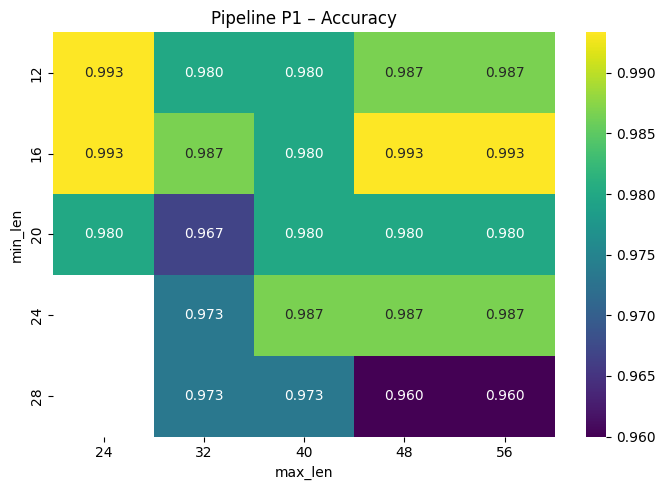

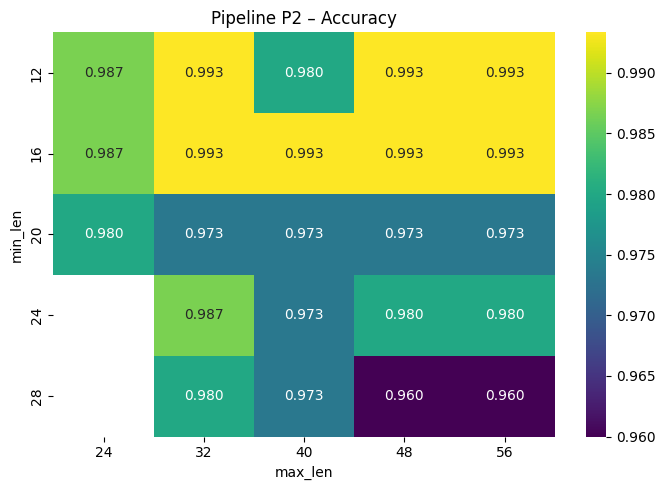

In [49]:
import seaborn as sns


def plot_heatmap(df, value, title):
    pivot = df.pivot(
        index="min_len",
        columns="max_len",
        values=value
    )

    plt.figure(figsize=(7, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".3f",
        cmap="viridis"
    )
    plt.title(title)
    plt.xlabel("max_len")
    plt.ylabel("min_len")
    plt.tight_layout()
    plt.show()

plot_heatmap(df_l_variation, "P1_acc", "Pipeline P1 – Accuracy")
plot_heatmap(df_l_variation, "P2_acc", "Pipeline P2 – Accuracy")


# Other datasets 

In [50]:
def run_shapelet_report(
    dataset_name,
    load_fn,
    k_baseline=50,
    tau=0.25,
    clf=None,
):
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*60}")

    X_train, y_train, X_test, y_test = load_fn()

    min_l, max_l = EstimateMinAndMax(X_train, y_train)
    print(f"Estimated lengths: [{min_l}, {max_l}]")

    baseline_shapelets = ShapeletCachedSelection(
        X_train, y_train,
        min_len=min_l,
        max_len=max_l,
        k=k_baseline,
        quality_method="f_stat"
    )

    clustered_shapelets = remove_inter_series_redundancy(
        baseline_shapelets,
        threshold_ratio=tau
    )


    Xtr_base = transform_dataset(X_train, baseline_shapelets)
    Xte_base = transform_dataset(X_test, baseline_shapelets)
    Xtr_ours = transform_dataset(X_train, clustered_shapelets)
    Xte_ours = transform_dataset(X_test, clustered_shapelets)

    if clf is None:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(Xtr_base, y_train)
    acc_base = accuracy_score(y_test, clf.predict(Xte_base))

    clf.fit(Xtr_ours, y_train)
    acc_ours = accuracy_score(y_test, clf.predict(Xte_ours))

    return {
        "dataset": dataset_name,
        "baseline_shapelets": baseline_shapelets,
        "clustered_shapelets": clustered_shapelets,
        "acc_base": acc_base,
        "acc_ours": acc_ours,
        "k_base": len(baseline_shapelets),
        "k_ours": len(clustered_shapelets),
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
    }



def findBestDistanceAndIndex(series, shapelet):
    series = np.asarray(series)
    shapelet = np.asarray(shapelet)

    l = len(shapelet)
    m = len(series)

    shapelet_zn = z_norm(shapelet)

    best_dist = np.inf
    best_idx = -1

    for i in range(m - l + 1):
        window = series[i:i+l]
        window_zn = z_norm(window)

        dist = np.sum((shapelet_zn - window_zn) ** 2)

        if dist < best_dist:
            best_dist = dist
            best_idx = i

    return best_dist, best_idx




def plot_shapelet(shapelet, title=None):
    plt.figure(figsize=(4, 2))
    plt.plot(shapelet.data, lw=2)
    plt.title(title or f"Shapelet (len={len(shapelet.data)})")
    plt.tight_layout()
    plt.show()

def plot_shapelet_on_series(series, shapelet):
    s = shapelet.data
    dists, idx = findBestDistanceAndIndex(series, s)

    plt.figure(figsize=(6, 3))
    plt.plot(series, alpha=0.7)
    plt.plot(
        range(idx, idx+len(s)),
        series[idx:idx+len(s)],
        lw=3,
        color='red',
        label='Matched Subsequence'
    )
    plt.legend()
    plt.title("Shapelet Localization on Time Series")
    plt.tight_layout()
    plt.show()

def plot_extreme_samples(X, y, shapelet, top_k=2):
    dists = np.array(findDistances(X, shapelet.data))
    idx_sorted = np.argsort(dists)

    fig, axes = plt.subplots(1, top_k*2, figsize=(12, 3))

    for i in range(top_k):
        axes[i].plot(X[idx_sorted[i]])
        axes[i].set_title(f"Closest (y={y[idx_sorted[i]]})")

        axes[-(i+1)].plot(X[idx_sorted[-(i+1)]])
        axes[-(i+1)].set_title(f"Farthest (y={y[idx_sorted[-(i+1)]]})")

    plt.tight_layout()
    plt.show()



def z_norm(x, eps=1e-8):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + eps)


In [4]:
# === Datasets Loaders === 

import requests
import zipfile
import io
import numpy as np


def load_ucr_from_url(dataset_name, url):
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/91.0.4472.114 Safari/537.36'
        )
    }

    print(f"Downloading {dataset_name} from {url}...")
    r = requests.get(url, headers=headers)

    if r.status_code != 200:
        raise Exception(
            f"Failed to download {dataset_name}. "
            f"Status: {r.status_code}\n"
            f"Response: {r.text[:200]}"
        )

    if r.content[:2] != b'PK':
        raise Exception(
            f"{dataset_name}: downloaded file is not a zip archive "
            "(might be HTML)."
        )

    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except zipfile.BadZipFile:
        with open(f"debug_{dataset_name}.html", "wb") as f:
            f.write(r.content)
        raise Exception(
            f"{dataset_name}: BadZipFile error. "
            f"Saved debug_{dataset_name}.html."
        )

    print("Files in archive:", z.namelist())

    train_name = f"{dataset_name}_TRAIN.txt"
    test_name  = f"{dataset_name}_TEST.txt"

    if train_name not in z.namelist():
        raise Exception(
            f"{dataset_name}: {train_name} not found. "
            "Archive format may have changed to .ts"
        )

    train = np.loadtxt(z.open(train_name))
    test  = np.loadtxt(z.open(test_name))

    X_train = train[:, 1:]
    y_train = train[:, 0].astype(int)

    X_test = test[:, 1:]
    y_test = test[:, 0].astype(int)

    print(
        f"Loaded {dataset_name}: "
        f"Train {X_train.shape}, Test {X_test.shape}"
    )

    return X_train, y_train, X_test, y_test


def load_coffee():
    return load_ucr_from_url(
        "Coffee",
        "https://www.timeseriesclassification.com/aeon-toolkit/Coffee.zip"
    )


def load_ecg_fivedays():
    return load_ucr_from_url(
        "ECGFiveDays",
        "https://www.timeseriesclassification.com/aeon-toolkit/ECGFiveDays.zip"
    )

def load_synthetic_control():
    return load_ucr_from_url(
        "SyntheticControl",
        "https://www.timeseriesclassification.com/aeon-toolkit/SyntheticControl.zip"
    )



In [54]:
all_results = []

for name, loader in [
    ("GunPoint", load_gunpoint),
    ("ECGFiveDays", load_ecg_fivedays),
    ("Coffee", load_coffee),
    ("SyntheticControl", load_synthetic_control),
]:
    res = run_shapelet_report(name, loader)
    all_results.append(res)





DATASET: GunPoint
Files in archive: ['GunPoint.txt', 'GunPoint_TEST.arff', 'GunPoint_TEST.txt', 'GunPoint_TRAIN.arff', 'GunPoint_TRAIN.txt', 'GunPoint_TEST.ts', 'GunPoint_TRAIN.ts']
Loaded GunPoint: Train (50, 150), Test (150, 150)
Estimated lengths: [25, 34]
Transforming dataset shape (50, 150) with 50 shapelets...
Transforming dataset shape (150, 150) with 50 shapelets...
Transforming dataset shape (50, 150) with 31 shapelets...
Transforming dataset shape (150, 150) with 31 shapelets...

DATASET: ECGFiveDays
Files in archive: ['ECGFiveDays.txt', 'ECGFiveDays_TEST.arff', 'ECGFiveDays_TEST.txt', 'ECGFiveDays_TRAIN.arff', 'ECGFiveDays_TRAIN.txt', 'ECGFiveDays_TEST.ts', 'ECGFiveDays_TRAIN.ts']
Loaded ECGFiveDays: Train (23, 136), Test (861, 136)
Estimated lengths: [28, 48]
Transforming dataset shape (23, 136) with 50 shapelets...
Transforming dataset shape (861, 136) with 50 shapelets...
Transforming dataset shape (23, 136) with 38 shapelets...
Transforming dataset shape (861, 136) with

In [55]:
def get_top_shapelet(clustered_shapelets):
    return clustered_shapelets[0]  # déjà triés par qualité

def viz_shapelet_only(res, n_show=3):
    print(f"\n### {res['dataset']} — Top Shapelets")
    for i, s in enumerate(res["clustered_shapelets"][:n_show]):
        plot_shapelet(s, title=f"{res['dataset']} | Shapelet #{i}")

def viz_shapelet_localization(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    X, y = res["X_train"], res["y_train"]

    series_id = s.series_id
    print(f"\n{res['dataset']} — Shapelet localization on source series")
    plot_shapelet_on_series(X[series_id], s)

def viz_shapelet_cross_class(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    X, y = res["X_train"], res["y_train"]

    src_class = y[s.series_id]
    other_idx = np.where(y != src_class)[0][0]

    print(f"\n{res['dataset']} — Shapelet on different class")
    plot_shapelet_on_series(X[other_idx], s)

def viz_extreme_samples(res):
    s = get_top_shapelet(res["clustered_shapelets"])
    print(f"\n{res['dataset']} — Closest vs Farthest samples")
    plot_extreme_samples(
        res["X_train"],
        res["y_train"],
        s,
        top_k=2
    )



DATASET: GunPoint

### GunPoint — Top Shapelets


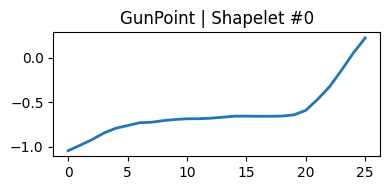

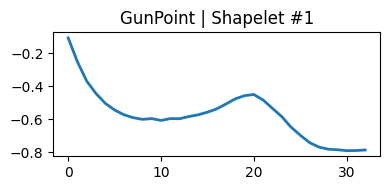

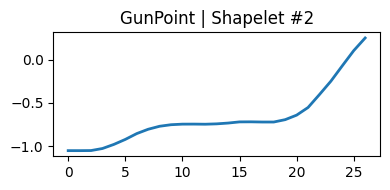


GunPoint — Shapelet localization on source series


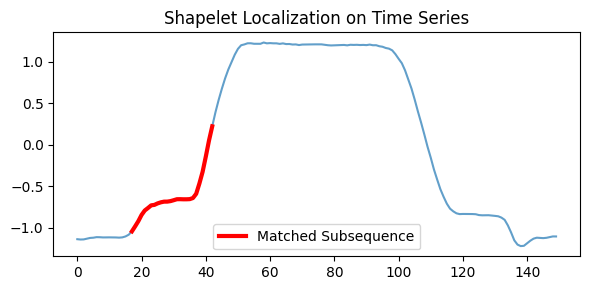


GunPoint — Shapelet on different class


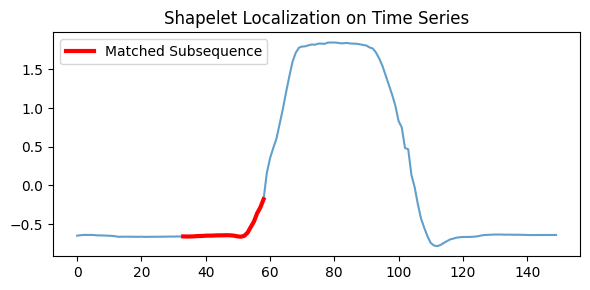


GunPoint — Closest vs Farthest samples


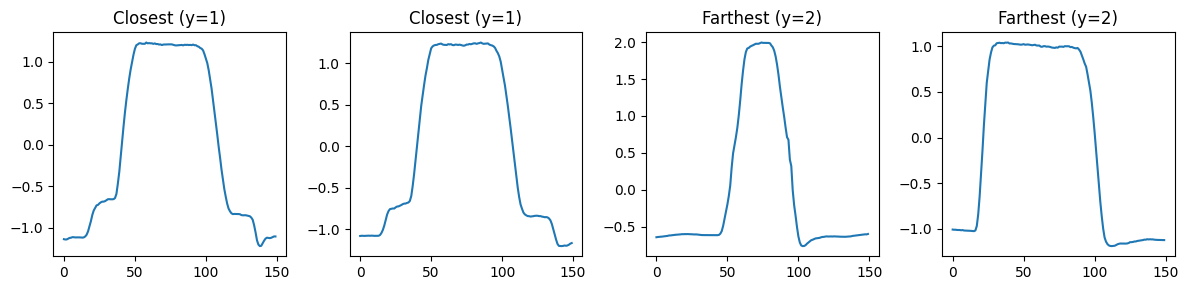


DATASET: ECGFiveDays

### ECGFiveDays — Top Shapelets


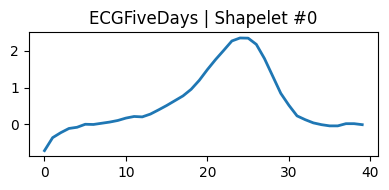

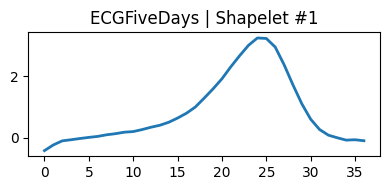

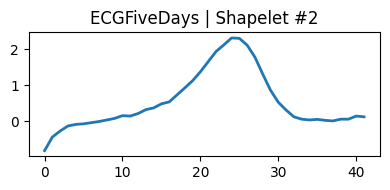


ECGFiveDays — Shapelet localization on source series


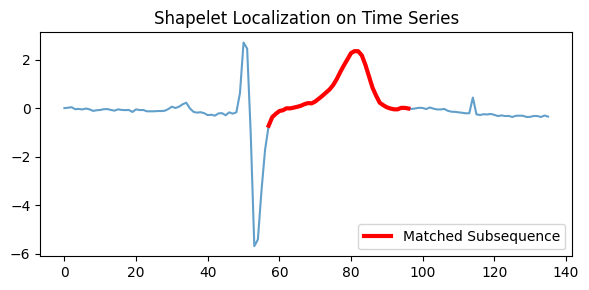


ECGFiveDays — Shapelet on different class


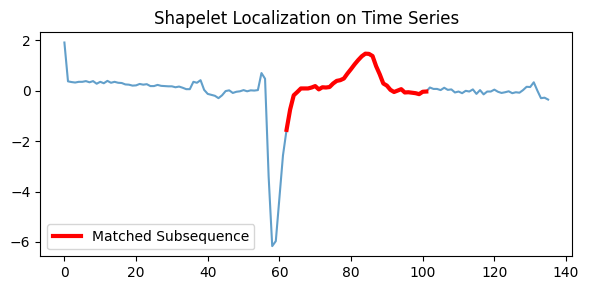


ECGFiveDays — Closest vs Farthest samples


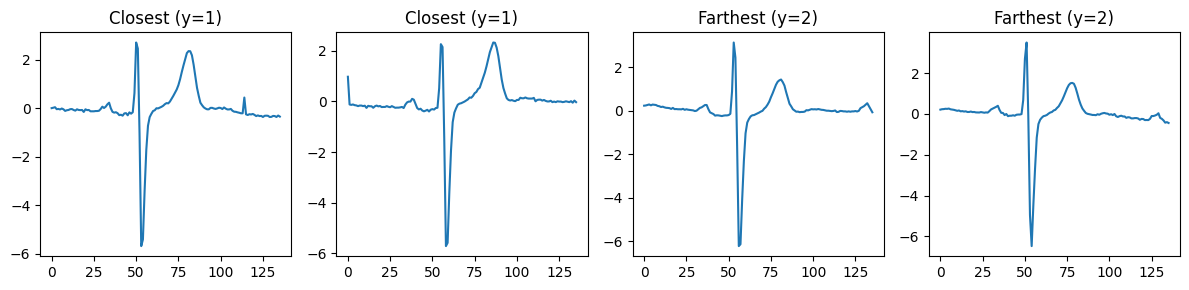


DATASET: Coffee

### Coffee — Top Shapelets


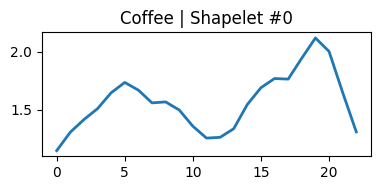

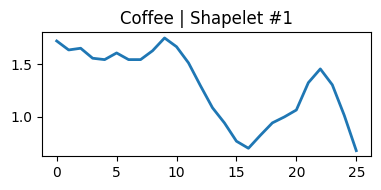

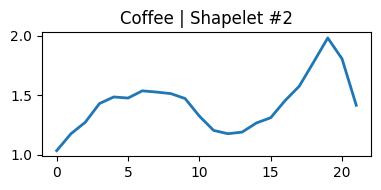


Coffee — Shapelet localization on source series


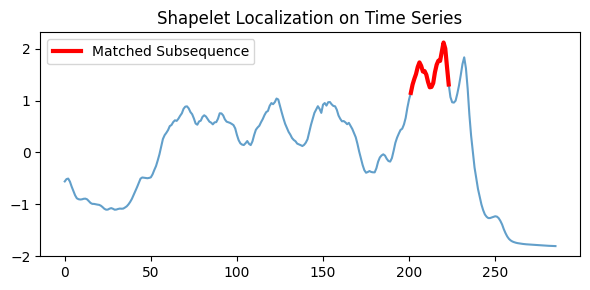


Coffee — Shapelet on different class


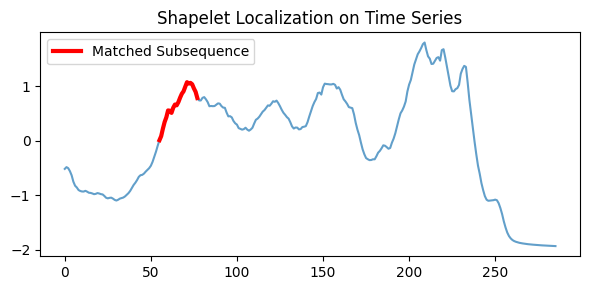


Coffee — Closest vs Farthest samples


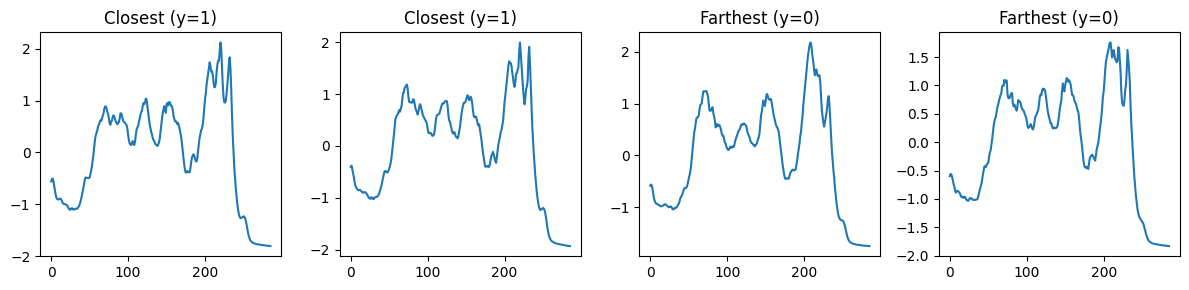


DATASET: SyntheticControl

### SyntheticControl — Top Shapelets


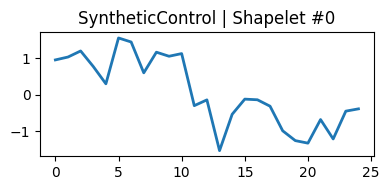

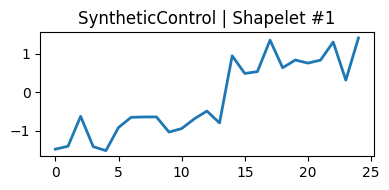

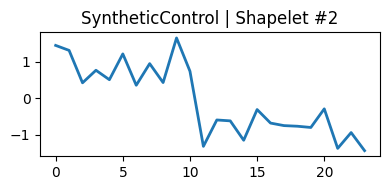


SyntheticControl — Shapelet localization on source series


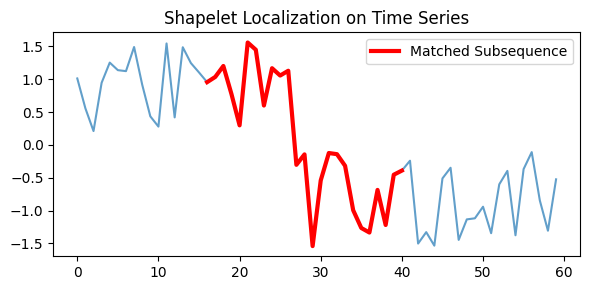


SyntheticControl — Shapelet on different class


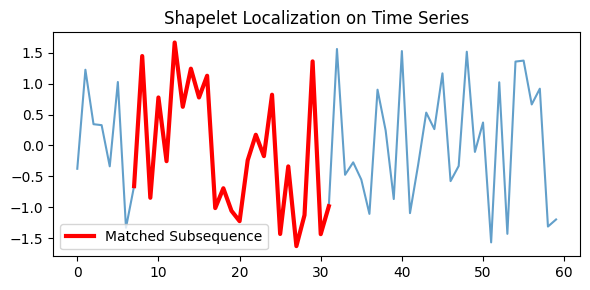


SyntheticControl — Closest vs Farthest samples


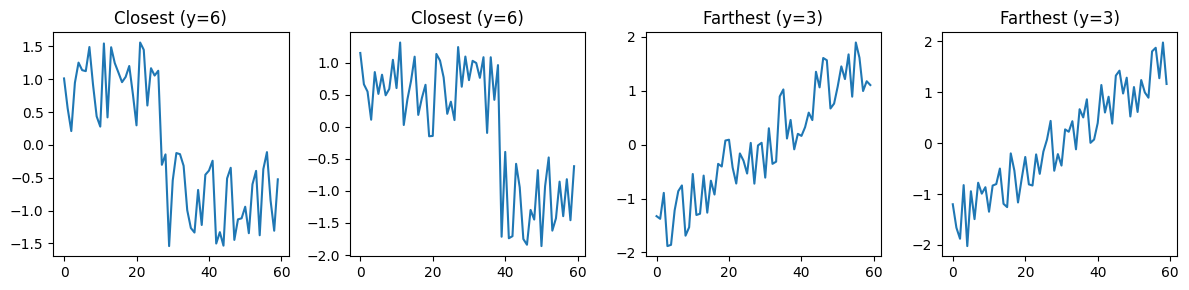

In [ ]:
for res in all_results:
    print("\n" + "="*80)
    print(f"DATASET: {res['dataset']}")
    print("="*80)

    # 1. Shapelets
    viz_shapelet_only(res, n_show=3)

    # 2. Localization on source
    viz_shapelet_localization(res)

    # 3. Cross-class localization
    viz_shapelet_cross_class(res)

    # 4. Extreme samples
    viz_extreme_samples(res)


In [58]:

rows = []

for res in all_results:
    base_shapelets = res["baseline_shapelets"]
    ours_shapelets = res["clustered_shapelets"]

    div_base = dictionary_diversity(base_shapelets)
    div_ours = dictionary_diversity(ours_shapelets)

    rows.append({
        "Dataset": res["dataset"],

        "Acc Baseline": res["acc_base"],
        "Acc Ours": res["acc_ours"],
        "Δ Acc": res["acc_ours"] - res["acc_base"],

        "k Baseline": len(base_shapelets),
        "k Ours": len(ours_shapelets),
        "Reduction (%)": 100 * (1 - len(ours_shapelets) / len(base_shapelets)),

        "Diversity Baseline": div_base,
        "Diversity Ours": div_ours,
        "Δ Diversity": div_ours - div_base,
    })

df_results = pd.DataFrame(rows)

df_display = df_results.copy()

for col in [
    "Acc Baseline", "Acc Ours", "Δ Acc",
    "Diversity Baseline", "Diversity Ours", "Δ Diversity",
    "Reduction (%)"
]:
    df_display[col] = df_display[col].astype(float).round(3)

print("\n" + "="*90)
print("COMPARISON: Standard Shapelet Transform vs Our Redundancy-Filtered Approach")
print("="*90)
print(df_display.to_string(index=False))
print("="*90)




COMPARISON: Standard Shapelet Transform vs Our Redundancy-Filtered Approach
         Dataset  Acc Baseline  Acc Ours  Δ Acc  k Baseline  k Ours  Reduction (%)  Diversity Baseline  Diversity Ours  Δ Diversity
        GunPoint         0.973     0.987  0.013          50      31           38.0                 inf             inf          NaN
     ECGFiveDays         1.000     1.000  0.000          50      38           24.0                 inf             inf          NaN
          Coffee         1.000     1.000  0.000          50      36           28.0                 inf             inf          NaN
SyntheticControl         0.967     0.967  0.000          50      50            0.0                 inf             inf          NaN


/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_2037/3812467345.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  "Δ Diversity": div_ours - div_base,


# ECG data analysis 

L’objectif de cette analyse est de comprendre :
- la structure temporelle du signal ECG,
- la variabilité intra-classe vs inter-classe,
- l’existence de motifs locaux discriminants (shapelets),
en cohérence avec l’analyse qualitative menée dans Hills et al. (2013).

In [77]:
X_train, y_train, X_test, y_test = load_ecg_fivedays()


print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Classes:", np.unique(y_train, return_counts=True))

Files in archive: ['ECGFiveDays.txt', 'ECGFiveDays_TEST.arff', 'ECGFiveDays_TEST.txt', 'ECGFiveDays_TRAIN.arff', 'ECGFiveDays_TRAIN.txt', 'ECGFiveDays_TEST.ts', 'ECGFiveDays_TRAIN.ts']
Loaded ECGFiveDays: Train (23, 136), Test (861, 136)
Train shape: (23, 136)
Test shape : (861, 136)
Classes: (array([1, 2]), array([14,  9]))


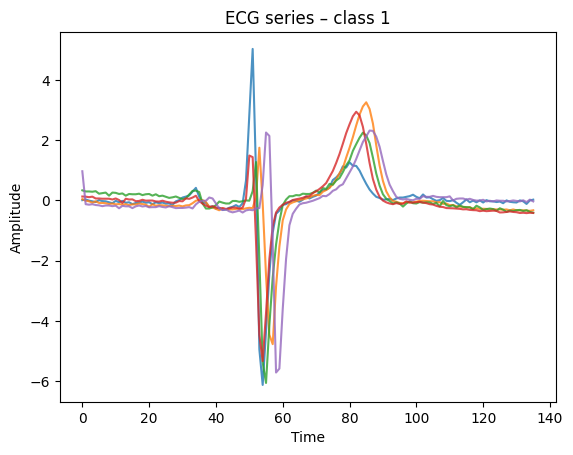

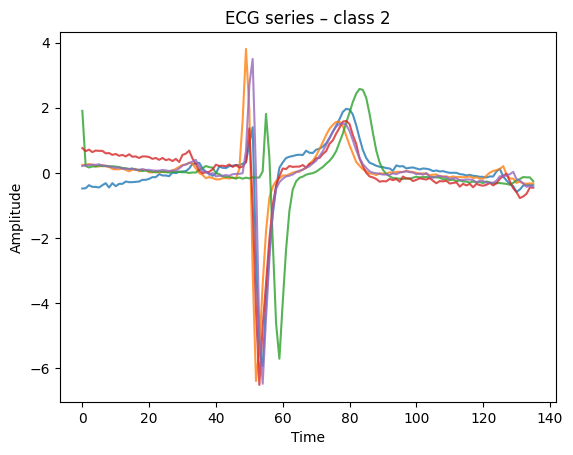

In [7]:
import matplotlib.pyplot as plt

def plot_random_series(X, y, cls, n=5):
    idx = np.where(y == cls)[0]
    sel = np.random.choice(idx, n, replace=False)
    for i in sel:
        plt.plot(X[i], alpha=0.8)
    plt.title(f"ECG series – class {cls}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

plot_random_series(X_train, y_train, cls=1)
plot_random_series(X_train, y_train, cls=2)


--- 1. COMPLETENESS CHECK ---
Total missing values: 0
-> Status: Clean (No imputation needed).

--- 2. CLASS BALANCE CHECK ---
   Class  Count  Percentage
0      1     14   60.869565
1      2      9   39.130435
-> Status: Imbalanced (Consider F1-Score or resampling).

--- 3. SCALE CONSISTENCY CHECK ---
Global Mean of Series Means: 0.00 (Std: 0.00)
Global Mean of Series Stds:  1.00 (Std: 0.00)
-> Status: Already Normalized.


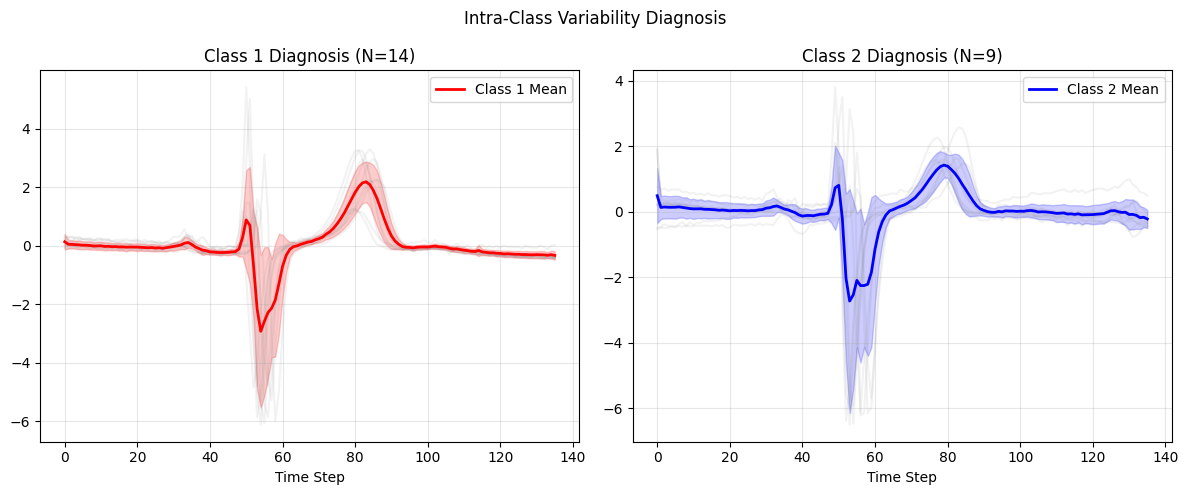

In [58]:
diagnose_dataset(X_train, y_train)




/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/994980890.py:85: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  freqs, psd = welch(X_c, fs=fs, axis=1)
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/994980890.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/994980890.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


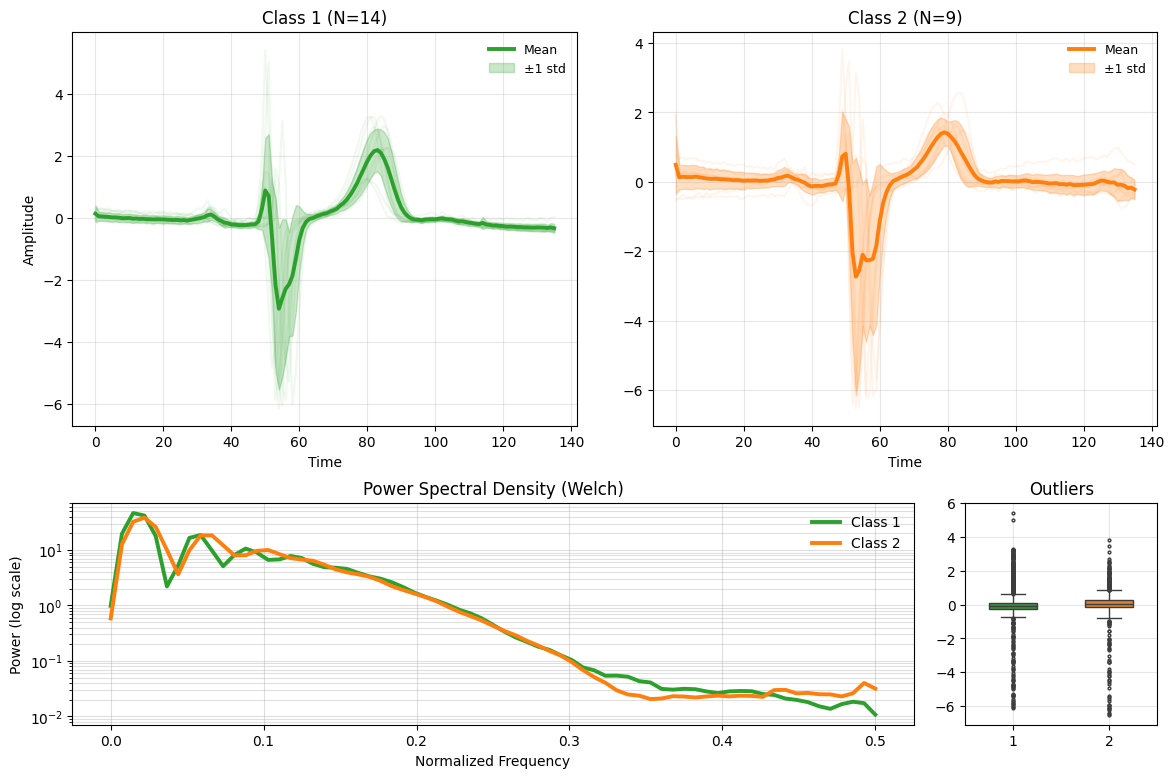

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from matplotlib.gridspec import GridSpec
def full_dataset_diagnosis_paper_ready(X, y, fs=1.0, max_overlay=10):

    classes = np.unique(y)

    BASE_COLORS = [
        "#2ca02c",  # green
        "#ff7f0e",  # orange
        "#1f77b4",  # blue
        "#d62728",  # red
    ]

    CLASS_COLORS = {
        c: BASE_COLORS[i % len(BASE_COLORS)]
        for i, c in enumerate(classes)
    }

    fig = plt.figure(figsize=(14, 9))

    gs_main = GridSpec(
        2, 1,
        height_ratios=[3.2, 1.8],
        hspace=0.25
    )

    # ===================== TOP: INTRA-CLASS =====================
    gs_top = gs_main[0].subgridspec(
        1, len(classes),
        wspace=0.15
    )

    # ==========================================================
    # 1. INTRA-CLASS VARIABILITY
    # ==========================================================
    for i, c in enumerate(classes):
        ax = fig.add_subplot(gs_top[0, i])
        color = CLASS_COLORS[c]

        X_c = X[y == c]
        mu = X_c.mean(axis=0)
        sigma = X_c.std(axis=0)

        for series in X_c[:max_overlay]:
            ax.plot(series, color=color, alpha=0.07)

        ax.plot(mu, color=color, linewidth=2.8, label="Mean")
        ax.fill_between(
            np.arange(len(mu)),
            mu - sigma,
            mu + sigma,
            color=color,
            alpha=0.25,
            label="±1 std"
        )

        ax.set_title(f"Class {c} (N={len(X_c)})")
        ax.set_xlabel("Time")
        if i == 0:
            ax.set_ylabel("Amplitude")

        ax.grid(alpha=0.3)
        ax.legend(frameon=False, fontsize=9)

    # ==========================================================
    # 2. PSD
    # ==========================================================
    gs_bottom = gs_main[1].subgridspec(
    1, 2,
    width_ratios=[3.5, 0.8],
    wspace=0.1
    )

    ax_psd = fig.add_subplot(gs_bottom[0, 0])
    ax_box = fig.add_subplot(gs_bottom[0, 1])

    for c in classes:
        X_c = X[y == c]
        color = CLASS_COLORS[c]

        freqs, psd = welch(X_c, fs=fs, axis=1)
        mean_psd = psd.mean(axis=0)

        ax_psd.semilogy(freqs, mean_psd, color=color, linewidth=2.8, label=f"Class {c}")

    ax_psd.set_title("Power Spectral Density (Welch)")
    ax_psd.set_xlabel("Normalized Frequency")
    ax_psd.set_ylabel("Power (log scale)")
    ax_psd.grid(True, which="both", alpha=0.4)
    ax_psd.legend(frameon=False)

    # ==========================================================
    # 3. BOXPLOT (OUTLIERS)
    # ==========================================================
    

    df_box = pd.DataFrame({
        "Amplitude": X.flatten(),
        "Class": np.repeat(y, X.shape[1])
    })

    sns.boxplot(
        x="Class",
        y="Amplitude",
        data=df_box,
        ax=ax_box,
        palette=[CLASS_COLORS[c] for c in classes],
        width=0.5,
        fliersize=2
    )

    ax_box.set_title("Outliers")
    ax_box.set_xlabel("")
    ax_box.set_ylabel("")
    ax_box.grid(alpha=0.3)

    #plt.suptitle("Full Dataset Diagnostic: Time, Frequency & Amplitude", fontsize=14)
    plt.tight_layout()
    plt.show()
  
full_dataset_diagnosis_paper_ready(X_train, y_train)

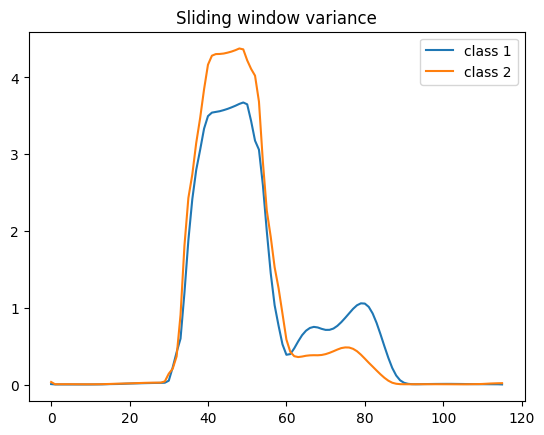

In [ ]:
def sliding_variance(X, window=20):
    return np.array([
        np.var(X[:, i:i+window], axis=1).mean()
        for i in range(X.shape[1] - window)
    ])

var0 = sliding_variance(X_train[y_train == 1])
var1 = sliding_variance(X_train[y_train == 2])

plt.plot(var0, label="class 1")
plt.plot(var1, label="class 2")
plt.legend()
plt.title("Sliding window variance")
plt.show()



Let's find the best shapelet for this dataset according to their method 

In [27]:
min_l, max_l = EstimateMinAndMax(X_train, y_train)
print(f"Estimated parameters: min_len={min_l}, max_len={max_l}")

print("\n--- 1. Baseline: Standard Shapelet Transform ---")
k_baseline = 50
print(f"Extracting top {k_baseline} shapelets (Standard)...")

shapelet_best = ShapeletCachedSelection(
    X_train, y_train, 
    min_len=min_l, 
    max_len=max_l, 
    k=k_baseline, 
    quality_method="f_stat"
)

Estimated parameters: min_len=6, max_len=37

--- 1. Baseline: Standard Shapelet Transform ---
Extracting top 50 shapelets (Standard)...


In [31]:
def min_distance_over_shapelets(shapelets, X):
    n_samples = len(X)
    n_shapelets = len(shapelets)

    D = np.zeros((n_samples, n_shapelets))
    for k, s in enumerate(shapelets):
        D[:, k] = findDistances(X, s.data)

    min_idx = np.argmin(D, axis=1)
    min_dist = D[np.arange(n_samples), min_idx]
    return min_dist, min_idx

min_dist, min_idx = min_distance_over_shapelets(shapelet_best, X_train)


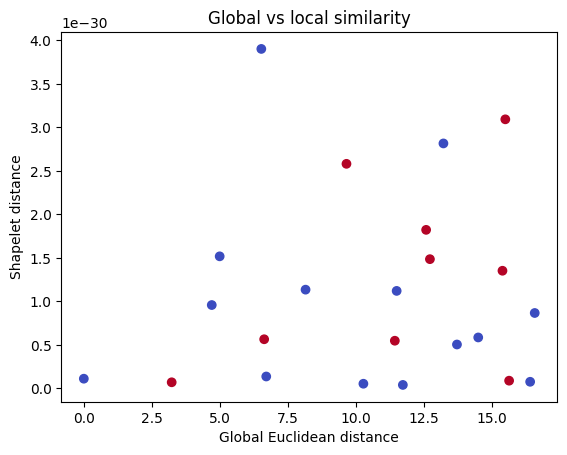

In [34]:
from scipy.spatial.distance import euclidean

def global_distances(X, ref):
    return np.array([euclidean(x, ref) for x in X])

ref = X_train[0]
dg = global_distances(X_train, ref)

plt.scatter(dg, min_dist, c=y_train, cmap="coolwarm")
plt.xlabel("Global Euclidean distance")
plt.ylabel("Shapelet distance")
plt.title("Global vs local similarity")
plt.show()


Summary :  
- Les classes ne sont pas séparables globalement
- Les différences sont locales et phase-indépendantes
- Certaines fenêtres temporelles sont fortement discriminantes
- La distance à un shapelet sépare nettement les classes

# DTW test 

In [82]:
# DTW implementation and comparison on GunPoint
import numpy as np
from numba import njit


@njit(fastmath=True)
def _dtw_distance(s, t, window):
    n = s.shape[0]
    m = t.shape[0]
    w = window
    if w < abs(n - m):
        w = abs(n - m)
    inf = 1e18
    dtw = np.full((n + 1, m + 1), inf)
    dtw[0, 0] = 0.0

    for i in range(1, n + 1):
        start = 1 if i - w < 1 else i - w
        end = m if i + w > m else i + w
        for j in range(start, end + 1):
            diff = s[i - 1] - t[j - 1]
            cost = diff * diff
            best = dtw[i - 1, j]
            if dtw[i, j - 1] < best:
                best = dtw[i, j - 1]
            if dtw[i - 1, j - 1] < best:
                best = dtw[i - 1, j - 1]
            dtw[i, j] = cost + best

    return dtw[n, m]


@njit(fastmath=True)
def findDistancesDTW(series_array, shapelet_array, window_ratio=0.1):
    n_series, series_len = series_array.shape
    shap_len = shapelet_array.shape[0]
    s_mean = np.mean(shapelet_array)
    s_std = np.std(shapelet_array)
    if s_std == 0.0:
        s_std = 1.0
    s_norm = (shapelet_array - s_mean) / s_std

    w = int(window_ratio * shap_len)
    if w < 1:
        w = 1

    output = np.empty(n_series)
    for i in range(n_series):
        ts = series_array[i]
        best_dist = 1e18
        for j in range(series_len - shap_len + 1):
            w_sum = 0.0
            w_sq = 0.0
            for k in range(shap_len):
                val = ts[j + k]
                w_sum += val
                w_sq += val * val
            w_mean = w_sum / shap_len
            w_std = np.sqrt((w_sq / shap_len) - (w_mean * w_mean))
            if w_std == 0.0:
                w_std = 1.0

            window = np.empty(shap_len)
            for k in range(shap_len):
                window[k] = (ts[j + k] - w_mean) / w_std

            dist = _dtw_distance(s_norm, window, w)
            if dist < best_dist:
                best_dist = dist

        output[i] = best_dist
    return output


def transform_dataset_dtw(X, shapelets, window_ratio=0.1):
    n_samples = len(X)
    n_features = len(shapelets)
    X_new = np.zeros((n_samples, n_features))

    print(f"Transforming dataset shape {X.shape} with {n_features} shapelets (DTW)...")
    for i, s in enumerate(shapelets):
        X_new[:, i] = findDistancesDTW(X, s.data, window_ratio=window_ratio)

    return X_new


if 'X_train' not in locals():
    X_train, y_train, X_test, y_test = load_ecg_fivedays()

min_l, max_l = EstimateMinAndMax(X_train, y_train)
print(f"Estimated parameters: min_len={min_l}, max_len={max_l}")

print("--- DTW vs Euclidean on ECG ---")
k_baseline = 50
print(f"Extracting top {k_baseline} shapelets (Standard)...")

shapelets_dtw_test = ShapeletCachedSelection(
    X_train, y_train,
    min_len=min_l,
    max_len=max_l,
    k=k_baseline,
    quality_method="f_stat"
)

X_train_euc = transform_dataset(X_train, shapelets_dtw_test)
X_test_euc = transform_dataset(X_test, shapelets_dtw_test)

X_train_dtw = transform_dataset_dtw(X_train, shapelets_dtw_test, window_ratio=0.1)
X_test_dtw = transform_dataset_dtw(X_test, shapelets_dtw_test, window_ratio=0.1)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_euc, y_train)
acc_euc = accuracy_score(y_test, clf.predict(X_test_euc))

clf.fit(X_train_dtw, y_train)
acc_dtw = accuracy_score(y_test, clf.predict(X_test_dtw))

print(f"Euclidean accuracy: {acc_euc:.4f}")
print(f"DTW accuracy:       {acc_dtw:.4f}")



Estimated parameters: min_len=18, max_len=28
--- DTW vs Euclidean on GunPoint ---
Extracting top 50 shapelets (Standard)...
Transforming dataset shape (23, 136) with 50 shapelets...
Transforming dataset shape (861, 136) with 50 shapelets...
Transforming dataset shape (23, 136) with 50 shapelets (DTW)...
Transforming dataset shape (861, 136) with 50 shapelets (DTW)...
Euclidean accuracy: 0.9965
DTW accuracy:       0.9988


# Mosquito Sound dataset 

Saved MosquitoSound to data/MosquitoSound.zip
MosquitoSound (subsampled): Train (1000, 3750), Test (1000, 3750)


/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/994980890.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dr/v65kt4vd74b0bqgk5_sy5npr0000gn/T/ipykernel_65593/994980890.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


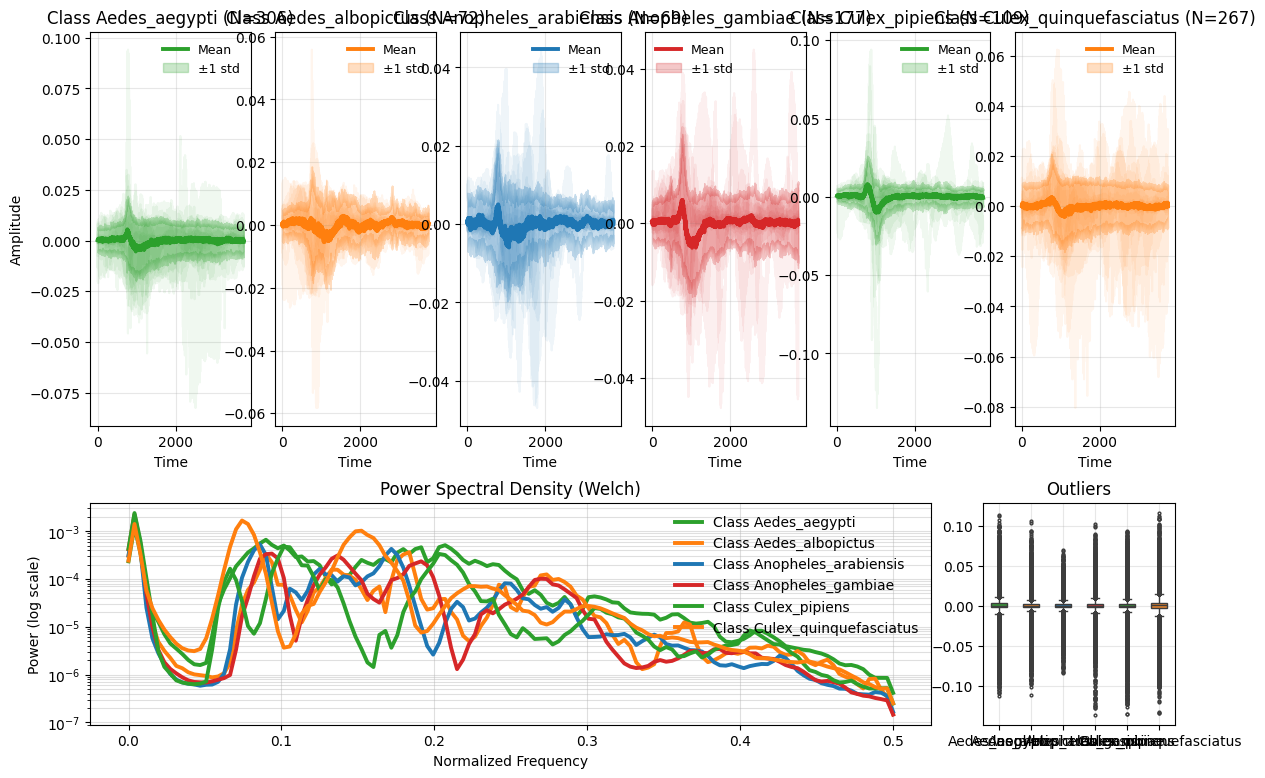

In [87]:
# MosquitoSound dataset: load + subsample + diagnosis (cached download)
import os
import numpy as np
import requests
import zipfile
import io
from sklearn.model_selection import StratifiedShuffleSplit


def _iter_arff_data_lines(f):
    in_data = False
    for raw in f:
        line = raw.decode("utf-8", errors="ignore").strip()
        if not line or line.startswith("%"):
            continue
        if not in_data:
            if line.lower().startswith("@data"):
                in_data = True
            continue
        yield line


def _count_labels_in_arff(z, arff_name):
    counts = {}
    with z.open(arff_name) as f:
        for line in _iter_arff_data_lines(f):
            parts = line.split(',')
            label = parts[-1].strip().strip('')
            counts[label] = counts.get(label, 0) + 1
    return counts


def _quota_from_counts(counts, n_samples):
    total = sum(counts.values())
    quotas = {}
    for k, v in counts.items():
        quotas[k] = int(round(n_samples * (v / total)))
    diff = n_samples - sum(quotas.values())
    keys = list(quotas.keys())
    i = 0
    while diff != 0 and keys:
        k = keys[i % len(keys)]
        quotas[k] += 1 if diff > 0 else -1
        diff = n_samples - sum(quotas.values())
        i += 1
    return quotas


def _stratified_reservoir_from_arff(z, arff_name, n_samples, seed=0):
    counts = _count_labels_in_arff(z, arff_name)
    quotas = _quota_from_counts(counts, n_samples)
    rng = np.random.RandomState(seed)

    kept = {k: [] for k in quotas}
    seen = {k: 0 for k in quotas}

    with z.open(arff_name) as f:
        for line in _iter_arff_data_lines(f):
            parts = line.split(',')
            label = parts[-1].strip().strip('')
            series = np.array(parts[:-1], dtype=float)
            seen[label] += 1
            q = quotas[label]
            if q <= 0:
                continue
            if len(kept[label]) < q:
                kept[label].append(series)
            else:
                j = rng.randint(0, seen[label])
                if j < q:
                    kept[label][j] = series

    X = []
    y = []
    for label, series_list in kept.items():
        X.extend(series_list)
        y.extend([label] * len(series_list))

    return np.array(X), np.array(y)


def _get_mosquito_zip(cache_dir="data"):
    os.makedirs(cache_dir, exist_ok=True)
    zip_path = os.path.join(cache_dir, "MosquitoSound.zip")
    if os.path.exists(zip_path):
        print(f"Using cached MosquitoSound at {zip_path}")
        return zip_path

    url = "https://www.timeseriesclassification.com/aeon-toolkit/MosquitoSound.zip"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/91.0.4472.114 Safari/537.36'
        )
    }

    print(f"Downloading MosquitoSound from {url}...")
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        raise Exception(f"Failed to download. Status: {r.status_code}")

    with open(zip_path, "wb") as f:
        f.write(r.content)

    print(f"Saved MosquitoSound to {zip_path}")
    return zip_path


def load_mosquito_sound_subsample(n_train=1000, n_test=1000, seed=0, cache_dir="data"):
    zip_path = _get_mosquito_zip(cache_dir=cache_dir)

    with zipfile.ZipFile(zip_path) as z:
        train_arff = "MosquitoSound/MosquitoSound_TRAIN.arff"
        test_arff = "MosquitoSound/MosquitoSound_TEST.arff"

        if train_arff not in z.namelist() or test_arff not in z.namelist():
            raise Exception("MosquitoSound: TRAIN/TEST arff files not found in archive.")

        X_train, y_train = _stratified_reservoir_from_arff(z, train_arff, n_train, seed=seed)
        X_test, y_test = _stratified_reservoir_from_arff(z, test_arff, n_test, seed=seed + 1)

    print(f"MosquitoSound (subsampled): Train {X_train.shape}, Test {X_test.shape}")
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_mosquito_sound_subsample(1000, 1000, seed=0)

full_dataset_diagnosis_paper_ready(X_train, y_train)



In [91]:
X_train, y_train, X_test, y_test = X_train[:20], y_train[:20], X_test[:20], y_test[:20]

In [92]:
# Baseline vs our pipeline on MosquitoSound (subsample)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

min_l, max_l = EstimateMinAndMax(X_train, y_train)
print(f"Estimated parameters: min_len={min_l}, max_len={max_l}")

print("--- 1. Baseline: Standard Shapelet Transform ---")
k_baseline = 50
print(f"Extracting top {k_baseline} shapelets (Standard)...")

baseline_shapelets = ShapeletCachedSelection(
    X_train, y_train,
    min_len=min_l,
    max_len=max_l,
    k=k_baseline,
    quality_method="f_stat"
)

print("--- 2. Our Method: Inter-Series Redundancy Filter ---")
clustered_shapelets = remove_inter_series_redundancy(baseline_shapelets, threshold_ratio=0.25)
print(f"Reduced feature space from {len(baseline_shapelets)} -> {len(clustered_shapelets)} features.")

print("--- 3. Training Classifiers ---")
X_train_base = transform_dataset(X_train, baseline_shapelets)
X_test_base  = transform_dataset(X_test, baseline_shapelets)

X_train_ours = transform_dataset(X_train, clustered_shapelets)
X_test_ours  = transform_dataset(X_test, clustered_shapelets)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_base, y_train)
acc_base = accuracy_score(y_test, clf.predict(X_test_base))

clf.fit(X_train_ours, y_train)
acc_ours = accuracy_score(y_test, clf.predict(X_test_ours))

print(f"Baseline accuracy: {acc_base:.4f}")
print(f"Ours accuracy:      {acc_ours:.4f}")



KeyboardInterrupt: 

In [ ]:
# Redundancy analysis of shapelets (baseline vs filtered)
import numpy as np
import matplotlib.pyplot as plt


def _shapelet_data_list(shapelets):
    return [s.data if hasattr(s, "data") else np.asarray(s) for s in shapelets]


def redundancy_report(shapelets, threshold_ratio=0.25):
    data_list = _shapelet_data_list(shapelets)
    n = len(data_list)
    if n < 2:
        print("Not enough shapelets for redundancy analysis.")
        return None

    # z-normalize shapelets for fair comparison
    zn = []
    for s in data_list:
        s = np.asarray(s)
        mu = s.mean()
        sigma = s.std()
        if sigma == 0.0:
            sigma = 1.0
        zn.append((s - mu) / sigma)

    dists = []
    near_dup = 0
    total = 0

    for i in range(n):
        si = zn[i]
        li = len(si)
        for j in range(i + 1, n):
            sj = zn[j]
            if len(sj) != li:
                continue  # only compare equal-length shapelets
            dist = np.linalg.norm(si - sj)
            dists.append(dist)
            total += 1
            if dist < (threshold_ratio * np.sqrt(li)):
                near_dup += 1

    if total == 0:
        print("No comparable shapelet pairs (length mismatch).")
        return None

    dists = np.array(dists)
    ratio = near_dup / total
    print(f"Pairs compared: {total}")
    print(f"Near-duplicates (< {threshold_ratio} * sqrt(L)): {near_dup} ({ratio*100:.1f}%)")

    plt.figure(figsize=(6, 4))
    plt.hist(dists, bins=30, color="gray", alpha=0.85)
    plt.title("Pairwise Shapelet Distances (z-norm)")
    plt.xlabel("Euclidean distance")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return dists


if 'baseline_shapelets' in locals():
    print("--- Redundancy: Baseline shapelets ---")
    redundancy_report(baseline_shapelets, threshold_ratio=0.25)

if 'clustered_shapelets' in locals():
    print("--- Redundancy: Filtered shapelets ---")
    redundancy_report(clustered_shapelets, threshold_ratio=0.25)

